# Exploration of Edinburgh's short rental market 
## Airbnb price prediction with Machine Learning.
*Keywords: Airbnb, Edinburgh, city, data, data science, design, geopandas, geospatial, gis, land use, livability, maps, matplotlib, modeling, neighborhood, networks, new urbanism, numpy, pandas, planning, python, smart cities, smart growth, urban, urban design, urban planning, visualization*

### 1. Project background and aim

 Airbnb is a internet marketplace for short-term home and apartment rentals. It allows you to, for example, rent out your home for a week while you’re away, or rent out your empty bedroom. One challenge that Airbnb hosts face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter by criteria like price, number of bedrooms, room type, and more. Since Airbnb is a market, the amount a host can charge is ultimately tied to market prices. The search experience on Airbnb looks like this: 
 
![alt text](Airbnb_sshot.png "Airbnb Edinburgh Search Results")
 
Although Airbnb provides hosts with general guidance, there are no easy to access methods to determine the best price to rent out a space. There is third-party software available, but for a hefty price (see an example on available software, click [here](https://beyondpricing.com/)).

One method could be to find a few listings that are similar to the place that will be up for rent, average the listed prices and set our price to this calculated average price. However, with the market being so dynamic, we would probably be looking to update the price regularly and this method can become tedious. 

Moreover, this may not be very accurate, as we are not taking into account other important factors that may give us a comparative advantage over other listings around us. This could be property characteristics such as number of rooms, bathrooms and extra services on offer. 

The aim of this project is to propose a data-driven solution, by using machine learning to predict rental price.

For this project, a predictor based on space will be introduced to the model: the property's proximity to certain venues. This will allow the model to put an implicit price on things such as living close to a bar or a supermarket.

### 2. Data Description

Airbnb does not release any data on the listings in its marketplace, a but separate group named [Inside Airbnb](http://insideairbnb.com/get-the-data.html) scrapes and compiles publicly available information about many cities Airbnb's listings from the Airbnb web-site. For this project, their data set scraped on July 21, 2019, on the city of Edinburgh, Scotland, is used. It contains information on all Edinburgh Airbnb listings that were live on the site on that date (over 14,000). Here's a [direct link](http://insideairbnb.com/edinburgh/).

The data has certain limitations. The most noticeable one is that it scrapes the advertised price rather than the actual price paid by previous customers. More accurate data is available for a fee in sites like [AirDNA](https://www.airdna.co/).

Each row in the data set is a listing available for rental in Airbnb's site for the specific city (observations). The columns describe different characteristics of each listing (features).

Some of the more important features this project will look into are the following: 

- `accommodates`: the number of guests the rental can accommodate
- `bedrooms`: number of bedrooms included in the rental
- `bathrooms`: number of bathrooms included in the rental
- `beds`: number of beds included in the rental
- `price`: nightly price for the rental
- `minimum_nights`: minimum number of nights a guest can stay for the rental
- `maximum_nights`: maximum number of nights a guest can stay for the rental
- `number_of_reviews`: number of reviews that previous guests have left

To model the spatial relationship between Airbnb rental prices and property proximity to certain venues, we use the [Foursquare API](https://developer.foursquare.com/) to access the city's venues and the street network, available though [OpenStreepMap (OSM)](https://www.openstreetmap.org/#map=12/55.9408/-3.1835).

#### Install required packages

In [ ]:
# general required packages
# %load basic_installs.py
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade cython

In [ ]:
# required package for timeseries
!{sys.executable} -m pip install statsmodels

In [ ]:
# requiered package to run geopandas
!conda install -c conda-forge libspatialindex -y

In [ ]:
# required packages for neighbourhood analysis
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests

In [ ]:
# requiered packages for accessibility analysis
# Make sure Cython is upgraded FIRST!
!{sys.executable} -m pip install pandana

In [ ]:
# requiered packages for modelling
!{sys.executable} -m pip install xgboost

In [45]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


### 3. Cleaning and Pre-processing

This section was based and adapted from [this very clear and complete notebook](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Categorical-features).

In [6]:
#!pwd to check the working directory
raw_df = pd.read_csv('/resources/Data_Science_Capstone/listings.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 14014 Airbnb listings


id                         listing_url       scrape_id last_scraped  \
0  15420  https://www.airbnb.com/rooms/15420  20190721133540   2019-07-21   
1  24288  https://www.airbnb.com/rooms/24288  20190721133540   2019-07-21   
2  38628  https://www.airbnb.com/rooms/38628  20190721133540   2019-07-21   

                                                name  \
0                  Georgian Boutique Apt City Centre   
1  Cool central Loft, sleeps 4, 2 double bed+en-s...   
2                              Edinburgh Holiday Let   

                                             summary  \
0  Stunning, impeccably refurbished spacious grou...   
1  Boho rustic-chic former warehouse Loft located...   
2  Brunstane - Daiches Braes (close to Portobello...   

                                               space  \
0  This is a huge and luxurious apartment for 2 -...   
1  Two bedroom, very central Loft apartment with ...   
2  Check out (Website hidden by Airbnb)  Free Wi-...   

                                         description experiences_offered  \
0  Stunning, impeccably refurbished spacious grou...                none   
1  Boho rustic-chic former warehouse Loft located...                none   
2  Brunstane - Daiches Braes (close to Portobello...                none   

                               neighborhood_overview  \
0  The neighbourhood is in the historic New Town,...   
1  It's all in the mix: Culture-museums and galle...   
2                  Quiet and easy access to outside.   

                                               notes  \
0  Please note that because of my interest in int...   
1  The apartment is in the City centre so being a...   
2  1.Brunstane -Daiches Braes  From the Airpor (W...   

                                             transit  \
0  It is easy to walk to many of the main tourist...   
1  Walk to key central attractions or catch a bus...   
2  From the Airpor (Website hidden by Airbnb)  Ge...   

                                              access  \
0  Guests have full access at the apartment.  All...   
1  The whole flat on the first floor and utility ...   
2  The owner will meet the guests on arrival if p...   

                                         interaction  \
0  Guests will be sent full details of what is su...   
1  Will meet guests on arrival and at check-out i...   
2  On arrival - I live upstairs and can help gues...   

                                         house_rules  thumbnail_url  \
0  The apartment is strictly non-smoking and we r...            NaN   
1  Non smokers only and no smoking in the buildin...            NaN   
2  No smoking in the apt- smoking permitted  on t...            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/cf69631f-4...   
1         NaN  https://a0.muscache.com/im/pictures/3460007/88...   
2         NaN  https://a0.muscache.com/im/pictures/d9885120-1...   

   xl_picture_url  host_id                                  host_url  \
0             NaN    60423   https://www.airbnb.com/users/show/60423   
1             NaN    46498   https://www.airbnb.com/users/show/46498   
2             NaN   165635  https://www.airbnb.com/users/show/165635   

   host_name  host_since                        host_location  \
0  Charlotte  2009-12-06  Edinburgh, Scotland, United Kingdom   
1     Gordon  2009-10-17  Edinburgh, Scotland, United Kingdom   
2      Trish  2010-07-13  Edinburgh, Scotland, United Kingdom   

                                          host_about  host_response_time  \
0  I have a background in property, having worked...  within a few hours   
1  Principal\r\nStudio DuB\r\nArchitecture & Plan...      within an hour   
2  Hi \r\nI like travelling and housing projects ...      within an hour   

  host_response_rate  host_acceptance_rate host_is_superhost  \
0               100%                   NaN                 t   
1               100%                   NaN         

#### Droping initial columns


Natural Language Processing will not be used in the creation of this model. Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [7]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Columns with several `NULL` entries are dropped too. 

In [8]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         21
host_response_time                               3491
host_response_rate                               3491
host_acceptance_rate                            14014
host_is_superhost                                  21
host_listings_count                                21
host_total_listings_count                          21
host_has_profile_pic                               21
host_identity_verified                             21
street                                              0
neighbourhood                                    2454
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    14014
city                                               15
state                                            2547
zipcode                                           217
market                      

In [9]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 
         'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # ID as index

`host_listings_count` and `host_total_listings_count` are the same in all but 248 cases. These cases are those where the value is `NaN`. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [10]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

21


experiences_offered host_since host_response_time host_response_rate  \
id                                                                              
6021786                 none        NaN                NaN                NaN   
7510076                 none        NaN                NaN                NaN   
9965620                 none        NaN                NaN                NaN   
10762221                none        NaN                NaN                NaN   
15377550                none        NaN                NaN                NaN   

         host_is_superhost  host_listings_count  host_total_listings_count  \
id                                                                           
6021786                NaN                  NaN                        NaN   
7510076                NaN                  NaN                        NaN   
9965620                NaN                  NaN                        NaN   
10762221               NaN                  NaN                        NaN   
15377550               NaN                  NaN                        NaN   

         host_has_profile_pic host_identity_verified  \
id                                                     
6021786                   NaN                    NaN   
7510076                   NaN                    NaN   
9965620                   NaN                    NaN   
10762221                  NaN                    NaN   
15377550                  NaN                    NaN   

                                        street neighbourhood  \
id                                                             
6021786    Edinburgh, Scotland, United Kingdom         Leith   
7510076              Edinburgh, United Kingdom     Southside   
9965620   Edinburgh, Edinburgh, United Kingdom      Old Town   
10762221      Dalry, Edinburgh, United Kingdom     Haymarket   
15377550   Edinburgh, Scotland, United Kingdom      West End   

                             neighbourhood_cleansed       city      state  \
id                                                                          
6021786                    Hillside and Calton Hill  Edinburgh   Scotland   
7510076                       Meadows and Southside  Edinburgh        NaN   
9965620   Old Town, Princes Street and Leith Street  Edinburgh  Edinburgh   
10762221                                Gorgie East      Dalry  Edinburgh   
15377550                              Deans Village  Edinburgh   Scotland   

          zipcode     market             smart_location country_code  \
id                                                                     
6021786   EH7 5ED  Edinburgh  Edinburgh, United Kingdom           GB   
7510076   EH3 9GD  Edinburgh  Edinburgh, United Kingdom           GB   
9965620   EH1 1QN  Edinburgh  Edinburgh, United Kingdom           GB   
10762221     EH11  Edinburgh      Dalry, United Kingdom           GB   
15377550  EH3 7RA  Edinburgh  Edinburgh, United Kingdom           GB   

                 country  latitude  longitude is_location_exact  \
id                                                                
6021786   United Kingdom  55.95941   -3.17751                 t   
7510076   United Kingdom  55.94315   -3.19404                 t   
9965620   United Kingdom  55.94991   -3.18744                 t   
10762221  United Kingdom  55.94352   -3.22677                 f   
15377550  United Kingdom  55.94925   -3.21634                 t   

               property_type        room_type  accommodates  bathrooms  \
id                                                                       
6021786            Apartment     Private room             1        1.0   
7510076            Apartment  Entire home/apt             6        2.0   
9965620            Apartment  Entire home/apt             4        2.0   
10762221           Apartment  Entire home/apt             6        1.0   
15377550  Serviced apartment  Entire home/apt             4        1.0   

          bedrooms

In [11]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in Edinburgh, columns relating to city and country can be dropped. One column for area will be kept, `neighboorhood_cleansed`.

In [13]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 
         'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. `minimum_nights` and `minimum_minimum_nights`. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [14]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1223

In [15]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

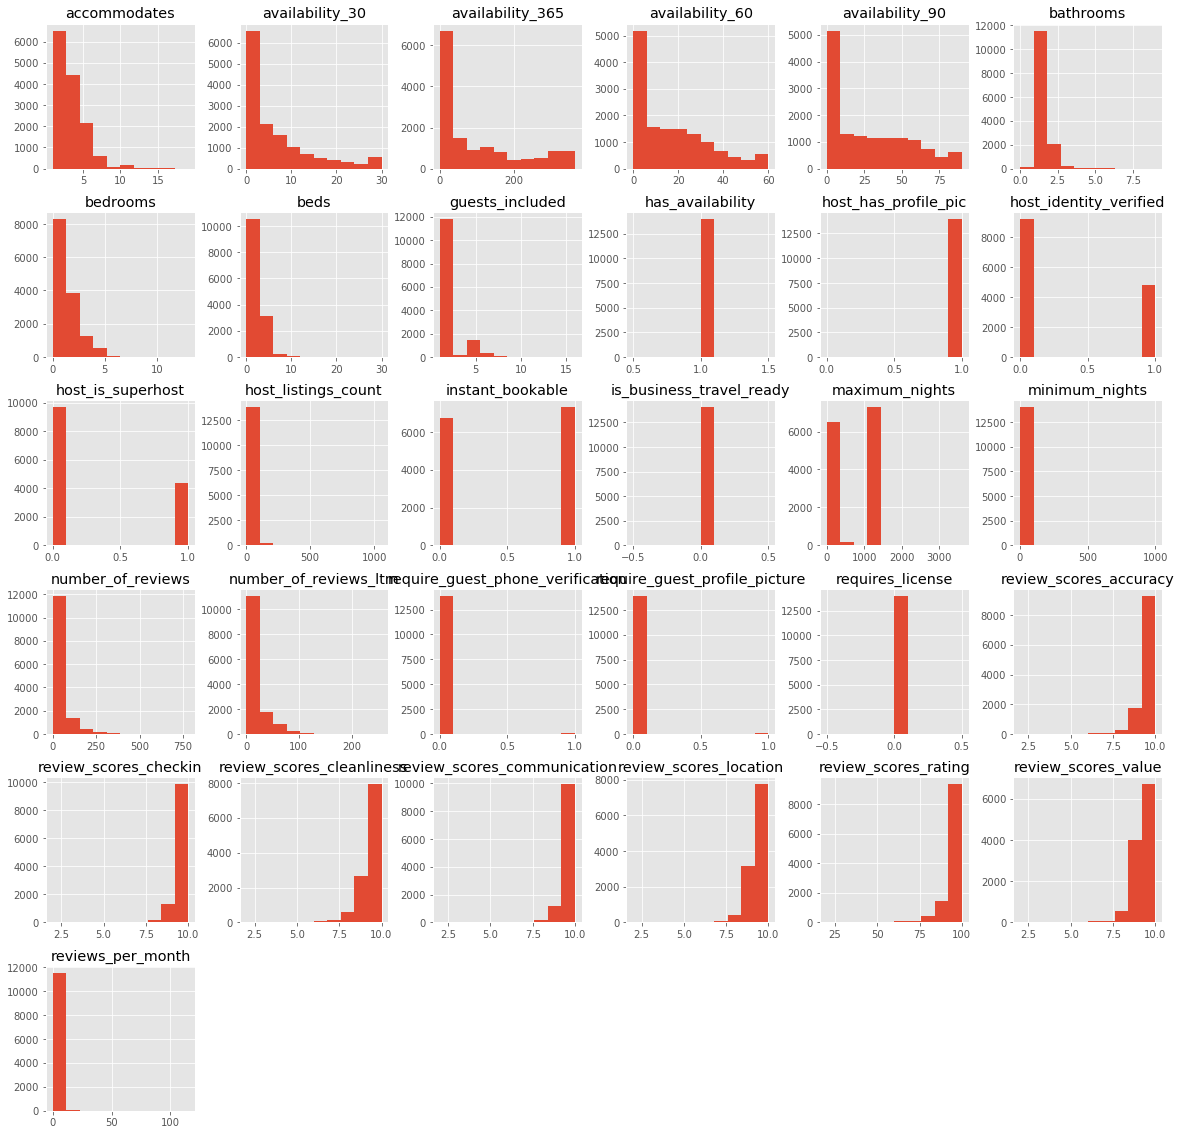

In [16]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [17]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 
         'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

#### Variables description:

- `experiences_offered` - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business

- `host_since` - date that the host first joined Airbnb

- `host_response_time` - average amount of time the host takes to reply to messages

- `host_response_rate` - proportion of messages that the host replies to

- `host_is_superhost` - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb

- `host_listings_count` - how many listings the host has in total

- `host_identity_verified` - whether or not the host has been verified with id

- `neighbourhood_cleansed` - the Edinburgh borough the property is in

- `property_type` - type of property, e.g. house or flat

- `room_type` - type of listing, e.g. entire home, private room or shared room

- `accommodates` - how many people the property accommodates

- `bathrooms` - number of bathrooms

- `bedrooms` - number of bedrooms

- `beds` - number of beds

- `bed_type` - type of bed, e.g. real bed or sofa-bed

- `amenities` - list of amenities

- `price` - nightly advertised price (the target variable)

- `security_deposit` - the amount required as a security deposit

- `cleaning_fee` - the amount of the cleaning fee (a fixed amount paid per booking)

- `guests_included` - the number of guests included in the booking fee

- `extra_people` - the price per additional guest above the guests_included price

- `minimum_nights` - the minimum length of stay

- `maximum_nights` - the maximum length of stay

- `calendar_updated` - when the host last updated the calendar

- `availability_30` - how many nights are available to be booked in the next 30 days

- `availability_60` - how many nights are available to be booked in the next 60 days

- `availability_90` - how many nights are available to be booked in the next 90 days

- `availability_365` - how many nights are available to be booked in the next 365 days

- `number_of_reviews` - the number of reviews left for the property

- `number_of_reviews_ltm` - the number of reviews left for the property in the last twelve months

- `first_review` - the date of the first review

- `last_review` - the date of the most recent review

- `review_scores_rating` - guests can score properties overall from 1 to 5 stars

- `review_scores_accuracy` - guests can score the accuracy of a property's description from 1 to 5 stars

- `review_scores_cleanliness` - guests can score a property's cleanliness from 1 to 5 stars

- `review_scores_checkin` - guests can score their check-in from 1 to 5 stars

- `review_scores_communication` - guests can score a host's communication from 1 to 5 stars

- `review_scores_location` - guests can score a property's location from 1 to 5 stars

- `review_scores_value` - guests can score a booking's value for money from 1 to 5 stars

- `instant_bookable` - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)

- `cancellation_policy` - the type of cancellation policy, e.g. strict or moderate

- `reviews_per_month` - calculated field of the average number of reviews left by guest each month

#### Cleaning individual columns

##### `Experiences_offered`

Most listings offer no experiences so this feature can be dropped.

In [18]:
df.experiences_offered.value_counts()

none    14014
Name: experiences_offered, dtype: int64

In [19]:
df.drop('experiences_offered', axis=1, inplace=True)

##### `host_since`

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (July 21, 2019). The original column will be left in initially for EDA, and dropped later.

In [20]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1313.0
Median days as host: 1283.0


##### `host_response_time`

About a third of rows don't have a value for `host_response_time`, and the majority of these have also not yet been reviewed. Therefore this section of the data set consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area.
Because `host_response_time` is unknown for so many listings, it will be retained as its own category, `'unknown'`.

In [21]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 3491
Proportion: 24.9%


2445

In [22]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.564007
unknown               0.249108
within a few hours    0.116954
within a day          0.061581
a few days or more    0.008349
Name: host_response_time, dtype: float64

In [23]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.564007
unknown               0.249108
within a few hours    0.116954
within a day          0.061581
a few days or more    0.008349
Name: host_response_time, dtype: float64

##### `host_response_rate`

A similar story is true for *host_response_rate*, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 75% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [24]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 3491
Proportion: 24.9%


In [25]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 97.0
Median host response rate: 100.0
Proportion of 100% host response rates: 81.5%


In [26]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       8571
unknown    3491
50-89%     1034
90-99%      741
0-49%       177
Name: host_response_rate, dtype: int64

##### `host_is_superhost`

There are 21 rows lacking values for each of five different host-related features. These rows will be dropped.

In [27]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 
                  'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

21

In [28]:
df.dropna(subset=['host_since'], inplace=True)

##### `property_type`

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories `Apartment`, `House` and `Other` will be used, as most properties can be classified as either apartment or house.

In [29]:
df.property_type.value_counts()

Apartment                 11262
House                      1352
Townhouse                   331
Condominium                 252
Bed and breakfast           128
Serviced apartment          124
Bungalow                    100
Boutique hotel               84
Hostel                       69
Cottage                      53
Guest suite                  51
Guesthouse                   46
Loft                         35
Villa                        33
Camper/RV                    19
Other                        15
Aparthotel                   10
Hotel                         6
Tent                          5
Cabin                         3
Farm stay                     2
Boat                          2
Casa particular (Cuba)        2
Tiny house                    2
Barn                          2
Campsite                      1
Hut                           1
Earth house                   1
Windmill                      1
Chalet                        1
Name: property_type, dtype: int64

In [30]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

##### `bathrooms`, `bedrooms` and `beds`

Missing values will be replaced with the median (to avoid strange fractions).

In [31]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

##### `bed_type`

Most listings have the same bed type, so it won't constitute a comparative advantage to have this feature. So this feature can be dropped.

In [32]:
df.bed_type.value_counts()

Real Bed         13866
Pull-out Sofa       86
Futon               31
Airbed               7
Couch                3
Name: bed_type, dtype: int64

In [33]:
df.drop('bed_type', axis=1, inplace=True)

##### `amenities`

Amenities is a list of additional features in the property, i.e. whether it has a TV or parking. Examples are below:

In [34]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,Internet,Wifi,"Wheelchair accessible",Kitchen,Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Lockbox,"High chair","Pack ’n Play/travel crib","Hot water","Bed linens","Extra pillows and blankets",Microwave,Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,"Luggage dropoff allowed"}'],
      dtype=object)

In [ ]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

In the list above, some amenities are more important than others (i.e. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (i.e.. 'Electric profiling bed'). For the purpose of this project, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):

- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [36]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

One way to reduce the number of features is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [37]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'gym', 'hot_tub_sauna_or_pool', 'smoking_allowed', 'accessible', 'event_suitable']


In [38]:
df.columns[40:]

Index(['bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'elevator', 'child_friendly', 'parking', 'outdoor_space',
       'host_greeting', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

##### `price`

Price will be converted to an integer. Currently it is a string because there is a currency sign.

In [39]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

##### `security_deposit`

As with price, this will be converted to an integer.

Having a missing value for security deposit is functionally the same as having a security deposit of £0, so missing values will be replaced with 0.

In [40]:
df.security_deposit.isna().sum()

5080

In [41]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

##### `cleaning_fee`

As with price, this will be converted to an integer.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of £0, so missing values will be replaced with 0.

In [42]:
df.cleaning_fee.isna().sum()

3995

In [43]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

##### `extra_people`

As with price, this will be converted to an integer.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of £0, so missing values will be replaced with 0.

In [44]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

##### `calendar_updated` 

There are 96 unique categories for *calendar_updated*, and it is not entirely clear what this feature is adding to the model (a host might update their calendar for multiple different reasons). Therefore this column will be dropped.

In [45]:
df.drop('calendar_updated', axis=1, inplace=True)

##### `availability`

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained, availability for 90 days (`availability_90`). This is due to the seemingly inevitable enforcement of London-like regulations proposed by the Scottish Government (90 days per year rents) after significant and growing concern from local residents and housing organisations over the increase of Airbnb and other short term lets within Edinburgh city, where there is now one Airbnb listing for every 11 residents.

In [46]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

##### `first_review` and `last_review`

Almost 20 percent of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information because reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are `NaN`s is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an `unknown` category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [114]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 17.5%
Null values in 'review_scores_rating': 18.5%


In [47]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

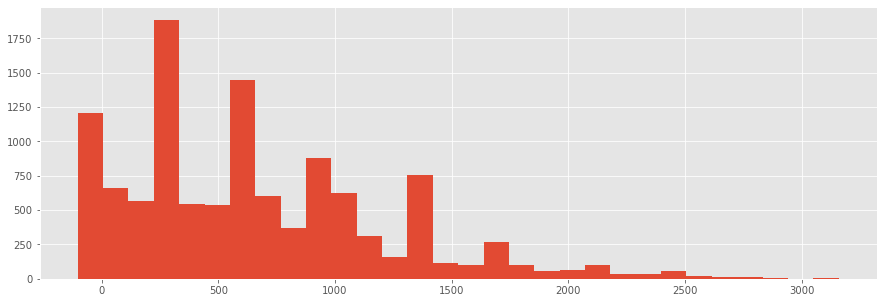

In [48]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [49]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [50]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

Same process for `last_review`

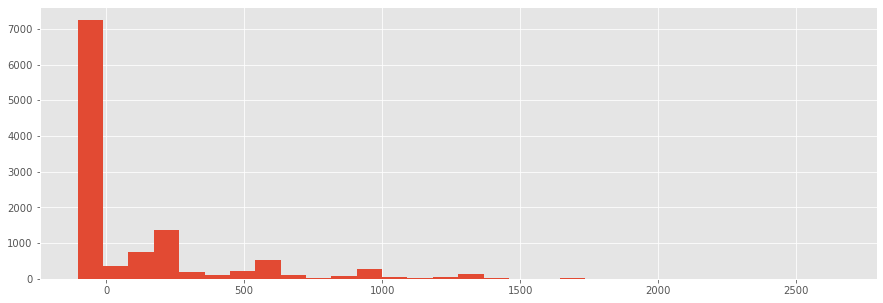

In [51]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [52]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [53]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

##### `review` ratings columns

As above, listings without reviews will be kept and replaced with `unknown`. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

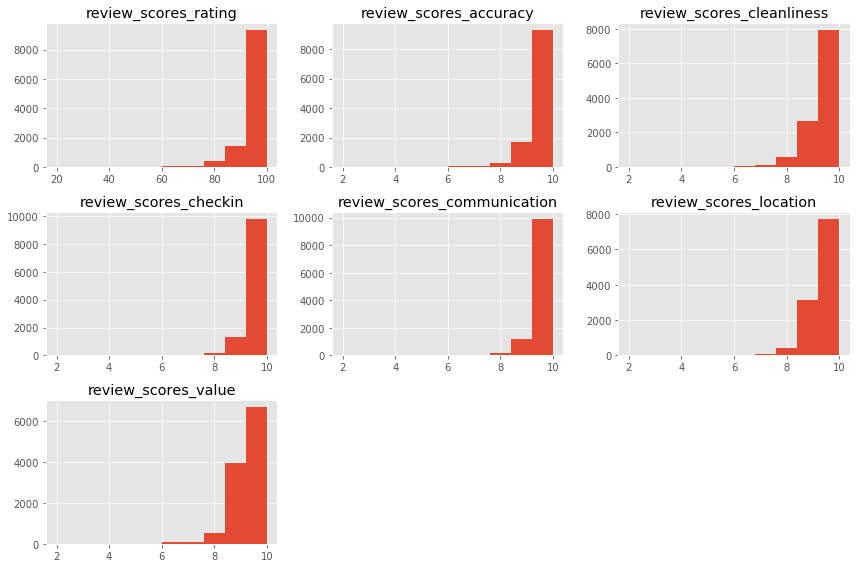

In [54]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [55]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [56]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [57]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

##### `cancellation_policy`

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [58]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    5734
moderate                       4203
flexible                       3859
super_strict_60                 156
super_strict_30                  41
Name: cancellation_policy, dtype: int64

In [59]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

##### `number_of_reviews_ltm` and `reviews_per_month`

These will be highly correlated with `number_of_reviews` and so will be dropped.

In [60]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [61]:
df.head()
df.dtypes

host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                     object
host_is_superhost                     float64
host_listings_count                   float64
host_identity_verified                float64
neighbourhood_cleansed                 object
property_type                          object
room_type                              object
accommodates                            int64
bathrooms                             float64
bedrooms                              float64
beds                                  float64
price                                   int64
security_deposit                        int64
cleaning_fee                            int64
guests_included                         int64
extra_people                            int64
minimum_nights                          int64
maximum_nights                          int64
availability_90                         int64
number_of_reviews                 

In [62]:
# Save cleaned dataset
listings_cleaned = df.to_csv(r'/resources/Data_Science_Capstone/listings_cleaned.csv', index=id, header=True)

### 4. Exploratory Data Analysis

#### Time Series

Time is an important factor to consider in a model when we wish to predict prices or trends. Enter **time series**. A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future. There are also other questions that come to play when dealing with time series. For example: Is there any *seasonality* to the price? Is it *stationary*? Even though we may not be able to include this aspect into our model, it is good to explore it to be aware of it and be able to make recommendations for future research. Thus, in this section, we will explore this aspect of the data.

For Airbnb prices, a high level of seasonality is expected due to the characteristics of the market. In August, during the Edinburgh Fringe Festival, room rental price rises considerably. Is an extremely popular event and much of the rented property available will have been taken up due to the number of people who attend each year. Edinburgh has lots of other art events throughout the year, mainly focused between April and December. There's word-class artists performing throughout these months. For the rest of the year, Edinburgh is uniquely placed as the cultural capital of, not just Scotland, but the UK. There's stable demand for accommodation and as well as tourism, because Edinburgh serves as a business capital after London.

In [63]:
# Read dataset
df = pd.read_csv('/resources/Data_Science_Capstone/listings_cleaned.csv', index_col=0)

In [64]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [65]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")


Of the Airbnb hosts that are still listing on the site, the first joined on 21 August 2009, and the most recent joined on 20 July 2019.


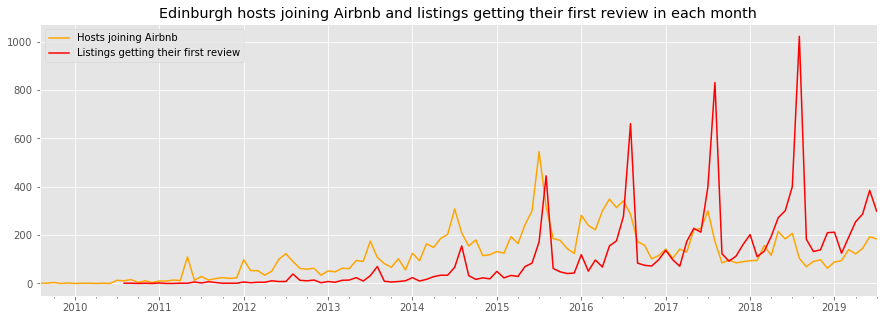

In [67]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Edinburgh hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-21', '2019-07-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [68]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [70]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

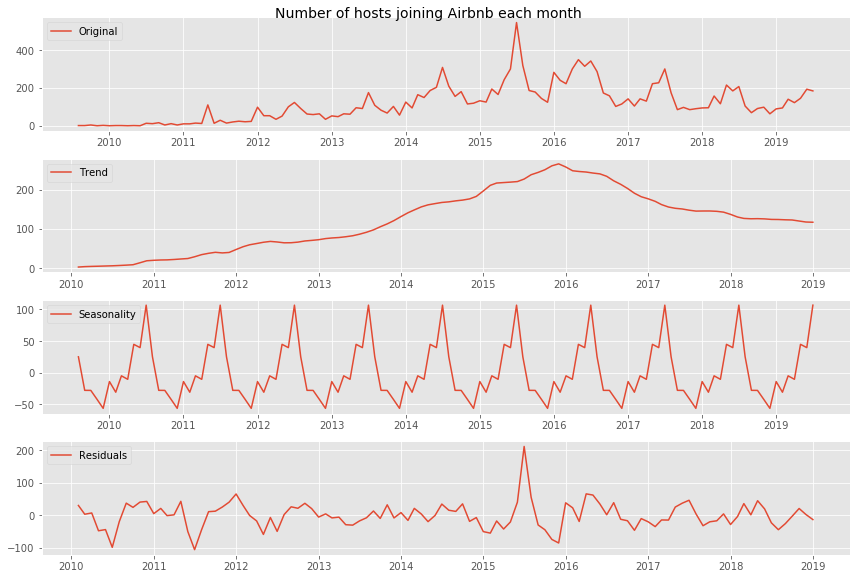

In [71]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

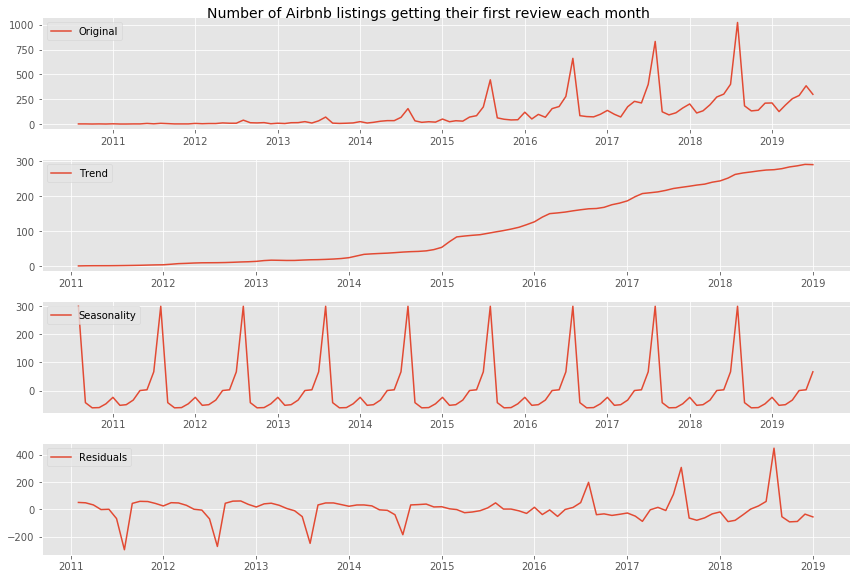

In [72]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

As seen above, there is a clear seasonality. Every year, you see a peak towards hosts joining around the middle of the year (summer), and the lowest points are the beginning and the end of each year. There is a big peak in the number of hosts joining Airbnb between 2015 and 2016. Indeed, there has been a fast growth of Airbnb since middle 2015, with clear peaks during Edinburgh Fringe Festival. This was the year when Airbnb became increasingly popular for short-term lease, as a way to get around local legislation and taxation. The same trend was observed in London, however, in London, the intriduction of the 90-day rule for short-term rentals is another variable to consider. That legislation did not apply to Edinburgh.

Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

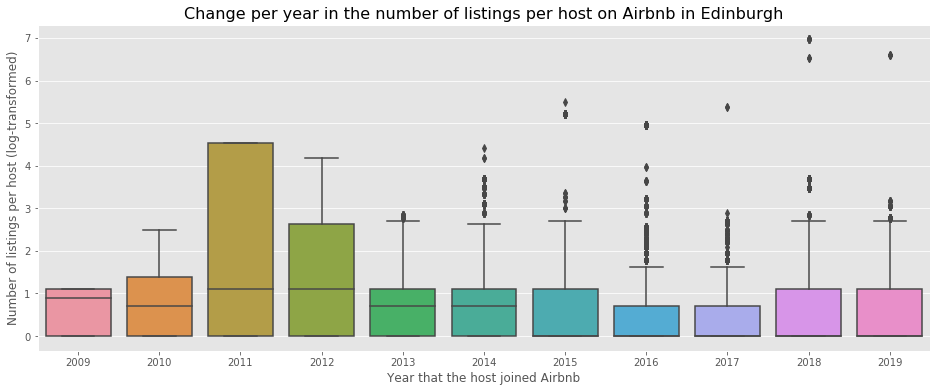

In [73]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Edinburgh', fontsize=16)
plt.show()

In [74]:
print("Average number of listings per host per year on Airbnb in Edinburgh:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Edinburgh:
host_since
2009-01-01     2.00
2010-01-01     3.84
2011-01-01    30.89
2012-01-01    11.07
2013-01-01     2.80
2014-01-01     4.81
2015-01-01    12.16
2016-01-01     5.12
2017-01-01     2.58
2018-01-01    13.33
2019-01-01     6.92
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [75]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
id                                      
32329025 2012-01-23                 65.0
36191940 2014-06-23                 83.0
35557763 2011-05-31                 94.0
34383709 2016-08-03                141.0
22342647 2015-07-05                183.0
22460811 2017-06-16                215.0
25735915 2015-03-05                243.0
33763561 2018-03-12                688.0
33798680 2019-01-07                735.0
30873108 2018-10-23               1058.0

In term of changes in prices over time, the average price per night for Airbnb listings in Edinburgh has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median. The mean price in 2010 was £107.33 and the median £115.0, whereas the mean price in 2018 (the last complete year of data) was £104.55 and the median £79.0.

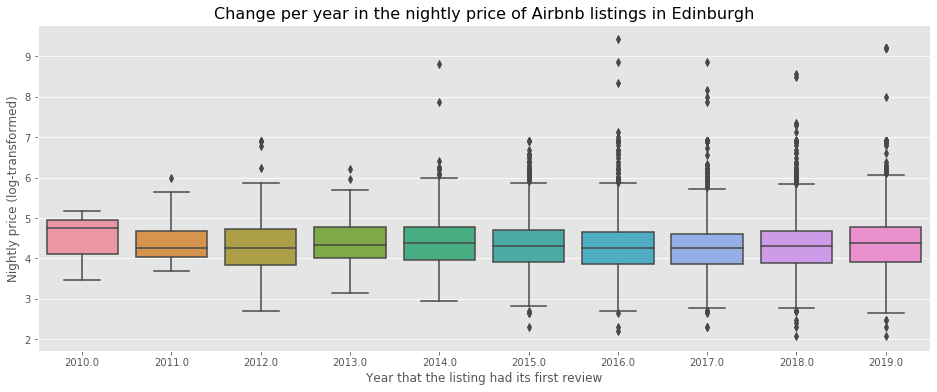

In [76]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Edinburgh', fontsize=16)
plt.show()

In [77]:
print("Mean nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2010-01-01    107.33
2011-01-01    102.12
2012-01-01    117.77
2013-01-01     95.17
2014-01-01    120.02
2015-01-01    102.02
2016-01-01    114.74
2017-01-01    101.03
2018-01-01    104.55
2019-01-01    173.33
Name: price, dtype: float64


In [78]:
print("Median nightly price of listings in each year on Airbnb in Edinburgh:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in Edinburgh:
first_review
2010-01-01    115.0
2011-01-01     70.5
2012-01-01     70.0
2013-01-01     76.0
2014-01-01     80.0
2015-01-01     74.0
2016-01-01     70.5
2017-01-01     70.0
2018-01-01     75.0
2019-01-01     79.0
Name: price, dtype: float64


In [79]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

#### Numerical Features

In [80]:
df.describe()

host_is_superhost  host_listings_count  host_identity_verified  \
count       13993.000000         13993.000000            13993.000000   
mean            0.309798             7.814264                0.341885   
std             0.462427            40.790954                0.474358   
min             0.000000             0.000000                0.000000   
25%             0.000000             1.000000                0.000000   
50%             0.000000             1.000000                0.000000   
75%             1.000000             3.000000                1.000000   
max             1.000000          1058.000000                1.000000   

       accommodates     bathrooms      bedrooms          beds         price  \
count  13993.000000  13993.000000  13993.000000  13993.000000  13993.000000   
mean       3.531837      1.230865      1.579147      2.016008    130.262488   
std        2.083692      0.541841      0.920224      1.557742    393.848998   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      1.000000      1.000000     50.000000   
50%        3.000000      1.000000      1.000000      2.000000     75.000000   
75%        4.000000      1.000000      2.000000      2.000000    120.000000   
max       19.000000      9.000000     13.000000     30.000000  12345.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      13993.000000  13993.000000     13993.000000  13993.000000   
mean          68.212964     21.140713         1.755664      6.605303   
std          147.905476     30.439089         1.495123     12.626504   
min            0.000000      0.000000         1.000000      0.000000   
25%            0.000000      0.000000         1.000000      0.000000   
50%            0.000000     10.000000         1.000000      0.000000   
75%          100.000000     35.000000         2.000000     10.000000   
max         3970.000000   2000.000000        16.000000    239.000000   

       minimum_nights  maximum_nights  availability_90  number_of_reviews  \
count    13993.000000    13993.000000     13993.000000       13993.000000   
mean         2.887873      607.783606        27.564711          37.111127   
std         15.619729      542.745129        26.836515          64.327332   
min          1.000000        1.000000         0.000000           0.000000   
25%          1.000000       30.000000         0.000000           2.000000   
50%          2.000000     1124.000000        21.000000          11.000000   
75%          2.000000     1125.000000        49.000000          43.000000   
max       1000.000000     3600.000000        90.000000         779.000000   

       instant_bookable  host_days_active     bed_linen     breakfast  \
count      13993.000000      13993.000000  13993.000000  13993.000000   
mean           0.520760       1312.858644      0.388266      0.181376   
std            0.499587        720.272578      0.487373      0.385344   
min            0.000000          1.000000      0.000000      0.000000   
25%            0.000000        779.000000      0.000000      0.000000   
50%            1.000000       1283.000000      0.000000      0.000000   
75%            1.000000       1805.000000      1.000000      0.000000   
max            1.000000       3621.000000      1.000000      1.000000   

                 tv  coffee_machine  cooking_basics   white_goods  \
count  13993.000000    13993.000000    13993.000000  13993.000000   
mean       0.713214        0.173158        0.366826      0.853141   
std        0.452277        0.378397        0.481956      0.353978   
min        0.000000        0.000000        0.000000      0.000000   
25%        0.000000        0.000000        0.000000      1.000000   
50%        1.000000        0.000000        0.000000      1.000000   
75%        1.000000        0.000000        1.000000      1.000000   
max        1.000000        1.000000        1.000000      1.000000   

           ele

`price`

Looking at price distribution, advertised prices range from £0 to £12,345. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

Unfortunately this model will be predicting advertised prices rather than the prices that were actually paid. Nonetheless, some cleaning of the particularly unhelpful values will be done. Very small values under £10 will be increased to £10.

There are notable drop-offs in prices at £200 (first graph, red line), £500 (second graph, green line) and £1,000 (second graph, red line). Values above £1,000 will be reduced to £1,000.

In [81]:
print(f"Advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Advertised prices range from £0 to £12345.


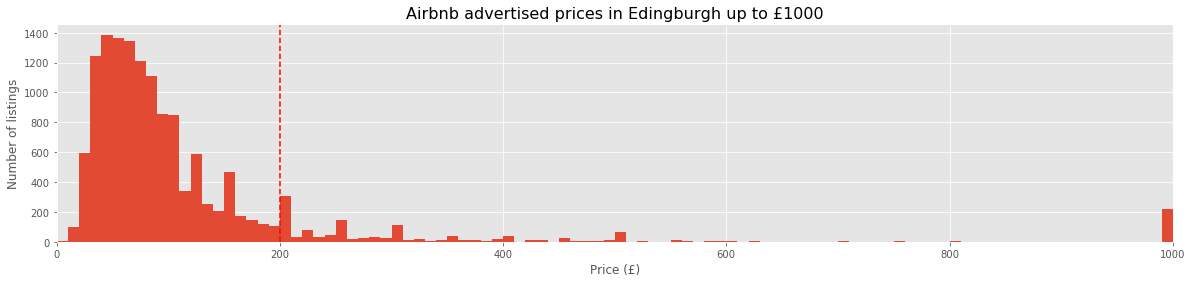

In [82]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Edingburgh up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

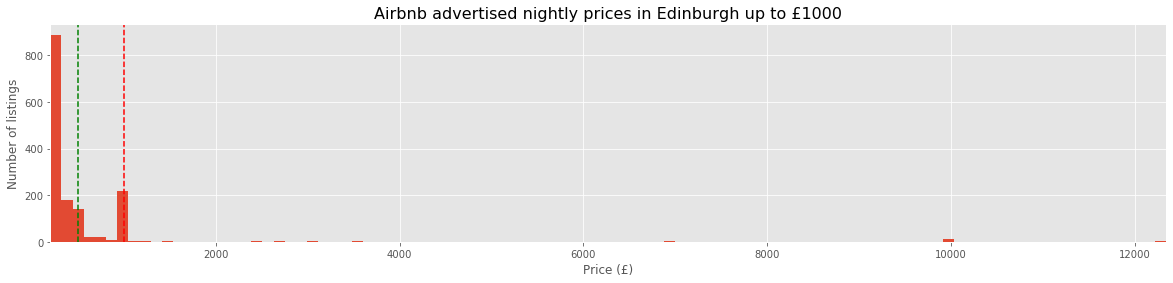

In [83]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Edinburgh up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [84]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

`host_listings_count`

The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is higher (8) due to some hosts managing some (very) large numbers of listings, as discussed above in the Time Series section. For example, the host with the highest number of listings has 1,058 listings under its ID. About half of listings are from hosts with one listing, and half are from multi-listing hosts.

Two difficulties in discerning how many listings hosts have on average are: 

1) this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)

2) a host's other listings may not be in Edinburgh, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [85]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df.host_listings_count.max())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 8
Highest number of listins per host: 1058
52% of listings are from hosts with one listing.


`accommodates`, `bathrooms`, `bedrooms` and `beds`

The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

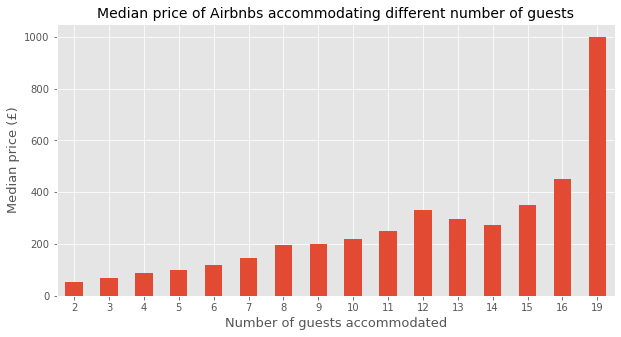

In [86]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

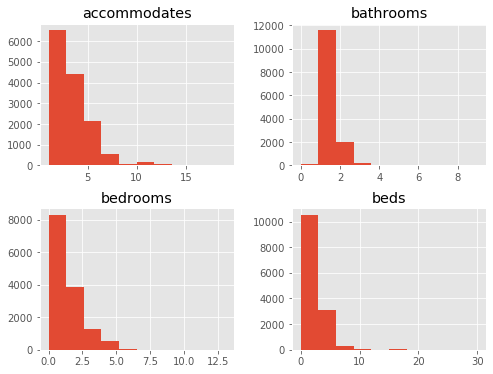

In [87]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

#### Categorical Features

`Neighbourhood`

Much of Airbnb listings are centred around Edinburgh's Old Town, which is consistent with the huge draw for tourists especially during the annual Fringe festival. 

In [89]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Edinburgh borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file(r'/resources/Data_Science_Capstone/neighbourhoods.geojson')
map_df.head()

neighbourhood neighbourhood_group  \
0  Balerno and Bonnington Village                None   
1                     Currie West                None   
2                     Currie East                None   
3      Baberton and Juniper Green                None   
4        Bonaly and The Pentlands                None   

                                            geometry  
0  MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...  
1  MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...  
2  MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...  
3  MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...  
4  MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...

In [90]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

geometry  \
neighbourhood                                                                       
Balerno and Bonnington Village  MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...   
Currie West                     MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...   
Currie East                     MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...   
Baberton and Juniper Green      MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...   
Bonaly and The Pentlands        MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...   

                                number_of_listings  median_price  
neighbourhood                                                     
Balerno and Bonnington Village                  22          75.0  
Currie West                                     19          40.0  
Currie East                                     16          47.5  
Baberton and Juniper Green                      22          49.5  
Bonaly and The Pentlands                        32          69.0

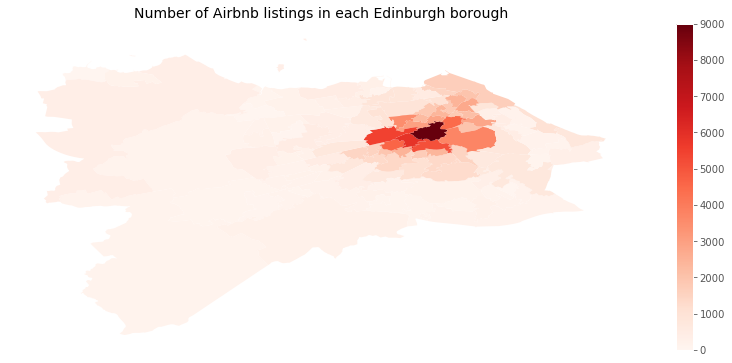

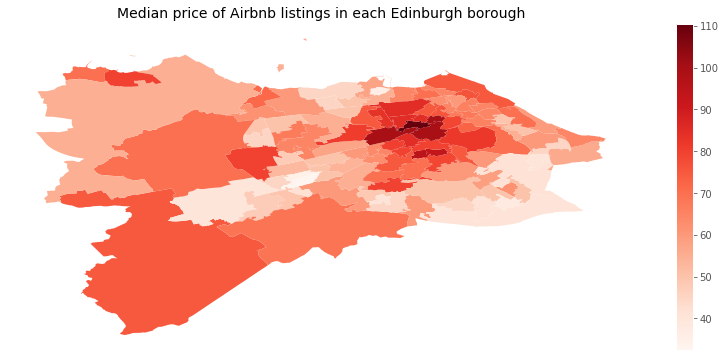

In [91]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

`property_type` and `room_type` 

About 80% of properties are apartments/flats. The remainder are houses or more uncommon property types (e.g. `bed and breakfast`).

About 62% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [92]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

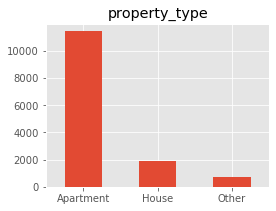

Apartment    0.816194
House        0.133853
Other        0.049954
Name: property_type, dtype: float64


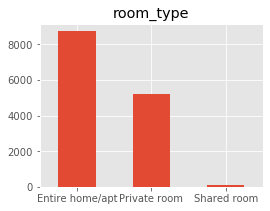

Entire home/apt    0.623455
Private room       0.370900
Shared room        0.005646
Name: room_type, dtype: float64


In [93]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

`review` categories

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, over a quarter of listings have not yet been reviewed.

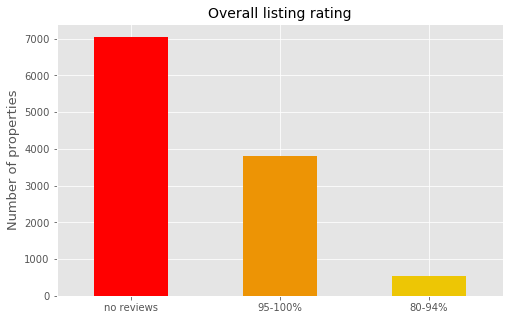

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['red', '#ed9405', '#edc605', '#ffec19' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

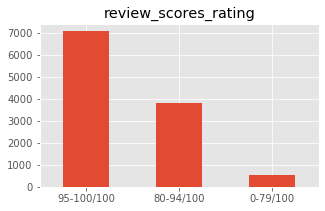

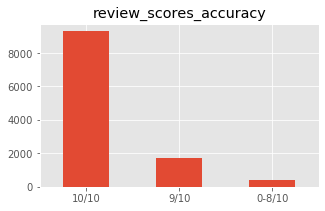

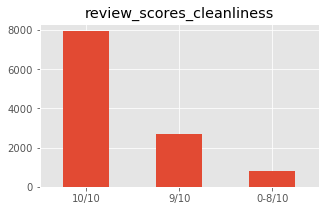

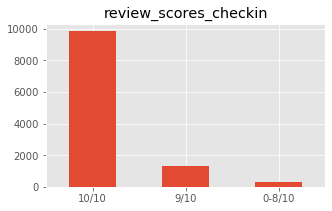

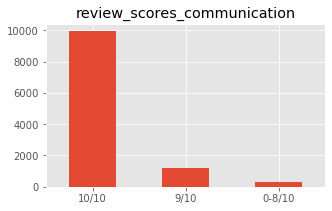

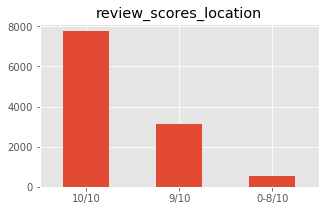

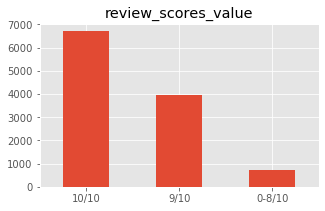

In [95]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

`first_review` and `last_review`

The most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 1+ years. This means that a lot of listings have not been reviewed recently. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

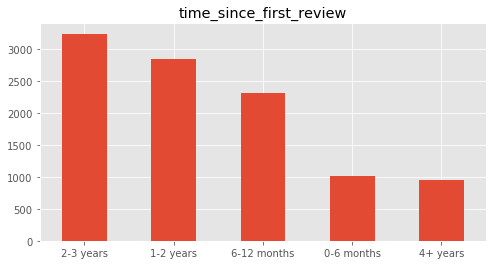

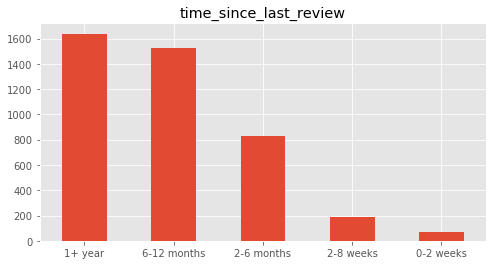

In [96]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

**Venue proximity**

As part of our model, we are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places maybe a deal-maker or breaker when it comes to choosing a accomodation. Proximity to certain venues, such as principal touristic attractions, restaurants, cafes and even shops could help us predict price. For this, we will use *Foursquare API* to explore the venues per neighbourhood. As discussed before, Old Town is the area which concentrates the majority of Airbnb listings. 

We now retrieve the list of venues with their locations. We will use *Foursquare API* to explore the venues around the listings, using the latitude and longitude of each neighbourhood. We dill then find out which venues are the most common and select the most common venues as points of interest (POIS) for our accessibility analysis.

In [ ]:
# Define Foursquare Credentials 

CLIENT_ID = # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [98]:
map_df.head()

neighbourhood  \
0  Balerno and Bonnington Village   
1                     Currie West   
2                     Currie East   
3      Baberton and Juniper Green   
4        Bonaly and The Pentlands   

                                            geometry  
0  MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...  
1  MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...  
2  MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...  
3  MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...  
4  MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...

We need the latitude and longitude of the neighbourhoods to retrieve the venues per neghbourhood. We can access this from the `geometry` column of our GeoDataFrame.

In [103]:
type(map_df.geometry)

geopandas.geoseries.GeoSeries

From `geometry` column in the GeoDataFrame, we can see that it returns a GeoSeries. To retrieve the venues per neighbourhood, we first extract the latitude and longitude or `x` and `y` from the point object in the GeoSeries. The following code returns `x` and `y` as separate GeoDataFrame columns within the original `map_df`. 

In [104]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [105]:
map_df.head()

neighbourhood  \
0  Balerno and Bonnington Village   
1                     Currie West   
2                     Currie East   
3      Baberton and Juniper Green   
4        Bonaly and The Pentlands   

                                            geometry  longitude   latitude  
0  MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...  -3.366086  55.866460  
1  MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...  -3.329488  55.905430  
2  MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...  -3.302739  55.903039  
3  MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...  -3.285077  55.907728  
4  MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...  -3.267223  55.888112

In [106]:
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood and create a new dataframe called *edinburgh_venues*.

In [ ]:
edinburgh_venues = getNearbyVenues(names=map_df['neighbourhood'],
                                   latitudes=map_df['latitude'],
                                   longitudes=map_df['longitude'],
                                 radius = 500
                                  )

Checking the size of the returning dataframe

In [108]:
print(edinburgh_venues.shape)
edinburgh_venues.head()

(1090, 7)


Neighbourhood  Neighbourhood Latitude  \
0                 Currie East               55.903039   
1                 Currie East               55.903039   
2  Baberton and Juniper Green               55.907728   
3  Baberton and Juniper Green               55.907728   
4  Baberton and Juniper Green               55.907728   

   Neighbourhood Longitude                            Venue  Venue Latitude  \
0                -3.302739                       Co-op Food       55.900378   
1                -3.302739        Pentlands Trekking Centre       55.903556   
2                -3.285077               Baberton Golf Club       55.906641   
3                -3.285077  Baberton Golf Course Club House       55.906364   
4                -3.285077                 The Pentland Fry       55.903255   

   Venue Longitude        Venue Category  
0        -3.307181         Grocery Store  
1        -3.298008               Stables  
2        -3.286638           Golf Course  
3        -3.289724                   Bar  
4        -3.285545  Fast Food Restaurant

In [111]:
#!pwd
# Saving Data set
edinburgh_venues.to_csv(r'/resources/Data_Science_Capstone/Edinburgh_Venues.csv')

In [110]:
# Read dataset
edinburgh_venues = pd.read_csv('/resources/Data_Science_Capstone/Edinburgh_Venues.csv', index_col=0)

Venues returned per neighbourhood

In [112]:
edinburgh_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                   
Abbeyhill                                                  21   
Baberton and Juniper Green                                  3   
Balgreen and Roseburn                                       4   
Barnton, Cammo and Cramond South                            4   
Bingham, Magdalene and The Christians                       5   
...                                                       ...   
Trinity                                                     4   
Trinity East and The Dudleys                                5   
West Pilton                                                 4   
Western Harbour and Leith Docks                            25   
Willowbrae and Duddingston Village                          4   

                                       Neighbourhood Longitude  Venue  \
Neighbourhood                                                           
Abbeyhill                                                   21     21   
Baberton and Juniper Green                                   3      3   
Balgreen and Roseburn                                        4      4   
Barnton, Cammo and Cramond South                             4      4   
Bingham, Magdalene and The Christians                        5      5   
...                                                        ...    ...   
Trinity                                                      4      4   
Trinity East and The Dudleys                                 5      5   
West Pilton                                                  4      4   
Western Harbour and Leith Docks                             25     25   
Willowbrae and Duddingston Village                           4      4   

                                       Venue Latitude  Venue Longitude  \
Neighbourhood                                                            
Abbeyhill                                          21               21   
Baberton and Juniper Green                          3                3   
Balgreen and Roseburn                               4                4   
Barnton, Cammo and Cramond South                    4                4   
Bingham, Magdalene and The Christians               5                5   
...                                               ...              ...   
Trinity                                             4                4   
Trinity East and The Dudleys                        5                5   
West Pilton                                         4                4   
Western Harbour and Leith Docks                    25               25   
Willowbrae and Duddingston Village                  4                4   

                                       Venue Category  
Neighbourhood                                          
Abbeyhill                                          21  
Baberton and Juniper Green                          3  
Balgreen and Roseburn                               4  
Barnton, Cammo and Cramond South                    4  
Bingham, Magdalene and The Christians               5  
...                                               ...  
Trinity                                             4  
Trinity East and The Dudleys                        5  
West Pilton                                         4  
Western Harbour and Leith Docks                    25  
Willowbrae and Duddingston Village                  4  

[107 rows x 6 columns]

**Unique categories of venues**

In [113]:
print('There are {} unique categories.'.format(len(edinburgh_venues['Venue Category'].unique())))

There are 182 unique categories.


**Number of venues per category**

In [114]:
edinburgh_venues.groupby('Venue Category').count()

Neighbourhood  Neighbourhood Latitude  \
Venue Category                                                  
African Restaurant                  3                       3   
Argentinian Restaurant              1                       1   
Art Gallery                        12                      12   
Art Museum                          1                       1   
Arts & Entertainment                2                       2   
...                               ...                     ...   
Wine Bar                            3                       3   
Wine Shop                           3                       3   
Wings Joint                         1                       1   
Yoga Studio                         3                       3   
Zoo Exhibit                         4                       4   

                        Neighbourhood Longitude  Venue  Venue Latitude  \
Venue Category                                                           
African Restaurant                            3      3               3   
Argentinian Restaurant                        1      1               1   
Art Gallery                                  12     12              12   
Art Museum                                    1      1               1   
Arts & Entertainment                          2      2               2   
...                                         ...    ...             ...   
Wine Bar                                      3      3               3   
Wine Shop                                     3      3               3   
Wings Joint                                   1      1               1   
Yoga Studio                                   3      3               3   
Zoo Exhibit                                   4      4               4   

                        Venue Longitude  
Venue Category                           
African Restaurant                    3  
Argentinian Restaurant                1  
Art Gallery                          12  
Art Museum                            1  
Arts & Entertainment                  2  
...                                 ...  
Wine Bar                              3  
Wine Shop                             3  
Wings Joint                           1  
Yoga Studio                           3  
Zoo Exhibit                           4  

[182 rows x 6 columns]

**Analysis per neighbourhood**

In [115]:
# One Hot Encoding
edinburgh_onehot = pd.get_dummies(edinburgh_venues[['Venue Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
edinburgh_onehot['Neighbourhood'] = edinburgh_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [edinburgh_onehot.columns[-1]] + list(edinburgh_onehot.columns[:-1])
edinburgh_onehot = edinburgh_onehot[fixed_columns]

# display
edinburgh_onehot.head()

Neighbourhood  African Restaurant  Argentinian Restaurant  \
0                 Currie East                   0                       0   
1                 Currie East                   0                       0   
2  Baberton and Juniper Green                   0                       0   
3  Baberton and Juniper Green                   0                       0   
4  Baberton and Juniper Green                   0                       0   

   Art Gallery  Art Museum  Arts & Entertainment  Asian Restaurant  \
0            0           0                     0                 0   
1            0           0                     0                 0   
2            0           0                     0                 0   
3            0           0                     0                 0   
4            0           0                     0                 0   

   Athletics & Sports  Auto Garage  Automotive Shop  Bagel Shop  Bakery  Bar  \
0                   0            0                0           0       0    0   
1                   0            0                0           0       0    0   
2                   0            0                0           0       0    0   
3                   0            0                0           0       0    1   
4                   0            0                0           0       0    0   

   Bathing Area  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Bike Shop  \
0             0      0                0         0            0          0   
1             0      0                0         0            0          0   
2             0      0                0         0            0          0   
3             0      0                0         0            0          0   
4             0      0                0         0            0          0   

   Bike Trail  Bistro  Botanical Garden  Bowling Alley  Boxing Gym  \
0           0       0                 0              0           0   
1           0       0                 0              0           0   
2           0       0                 0              0           0   
3           0       0                 0              0           0   
4           0       0                 0              0           0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridge  Burger Joint  \
0                     0               0        0       0             0   
1                     0               0        0       0             0   
2                     0               0        0       0             0   
3                     0               0        0       0             0   
4                     0               0        0       0             0   

   Burrito Place  Bus Station  Bus Stop  Business Service  Butcher  Cafeteria  \
0              0            0         0                 0        0          0   
1              0            0         0                 0        0          0   
2              0            0         0                 0        0          0   
3              0            0         0                 0        0          0   
4              0            0         0                 0        0          0   

   Café  Campground  Canal  Castle  Cheese Shop  Chinese Restaurant  Church  \
0     0           0      0       0            0                   0       0   
1     0           0      0       0            0                   0       0   
2     0           0      0       0            0                   0       0   
3     0           0      0       0            0                   0       0   
4     0           0      0       0            0                   0       0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Cafeteria  Comedy Club  \
0               0             0            0                  0            0   
1               0             0            0                  0            0   
2               0             0            0                  0            0   
3               0             0         

In [116]:
# New df dimensions
edinburgh_onehot.shape

(1090, 183)

**Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category**

In [117]:
edinburgh_grouped = edinburgh_onehot.groupby('Neighbourhood').mean().reset_index()
edinburgh_grouped

Neighbourhood  African Restaurant  \
0                                Abbeyhill                 0.0   
1               Baberton and Juniper Green                 0.0   
2                    Balgreen and Roseburn                 0.0   
3         Barnton, Cammo and Cramond South                 0.0   
4    Bingham, Magdalene and The Christians                 0.0   
..                                     ...                 ...   
102                                Trinity                 0.0   
103           Trinity East and The Dudleys                 0.0   
104                            West Pilton                 0.0   
105        Western Harbour and Leith Docks                 0.0   
106     Willowbrae and Duddingston Village                 0.0   

     Argentinian Restaurant  Art Gallery  Art Museum  Arts & Entertainment  \
0                       0.0     0.047619         0.0                   0.0   
1                       0.0     0.000000         0.0                   0.0   
2                       0.0     0.000000         0.0                   0.0   
3                       0.0     0.000000         0.0                   0.0   
4                       0.0     0.000000         0.0                   0.0   
..                      ...          ...         ...                   ...   
102                     0.0     0.000000         0.0                   0.0   
103                     0.0     0.000000         0.0                   0.0   
104                     0.0     0.000000         0.0                   0.0   
105                     0.0     0.000000         0.0                   0.0   
106                     0.0     0.000000         0.0                   0.0   

     Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0                 0.0                 0.0          0.0              0.0   
1                 0.0                 0.0          0.0              0.0   
2                 0.0                 0.0          0.0              0.0   
3                 0.0                 0.0          0.0              0.0   
4                 0.0                 0.0          0.2              0.0   
..                ...                 ...          ...              ...   
102               0.0                 0.0          0.0              0.0   
103               0.0                 0.0          0.0              0.0   
104               0.0                 0.0          0.0              0.0   
105               0.0                 0.0          0.0              0.0   
106               0.0                 0.0          0.0              0.0   

     Bagel Shop  Bakery       Bar  Bathing Area  Beach  Bed & Breakfast  \
0           0.0     0.0  0.047619           0.0    0.0              0.0   
1           0.0     0.0  0.333333           0.0    0.0              0.0   
2           0.0     0.0  0.000000           0.0    0.0              0.0   
3           0.0     0.0  0.000000           0.0    0.0              0.0   
4           0.0     0.0  0.000000           0.0    0.0              0.0   
..          ...     ...       ...           ...    ...              ...   
102         0.0     0.0  0.000000           0.0    0.0              0.0   
103         0.0     0.0  0.000000           0.0    0.0              0.0   
104         0.0     0.0  0.000000           0.0    0.0              0.0   
105         0.0     0.0  0.080000           0.0    0.0              0.0   
106         0.0     0.0  0.000000           0.0    0.0              0.0   

     Beer Bar  Beer Garden  Bike Shop  Bike Trail  Bistro  Botanical Garden  \
0         0.0          0.0        0.0        0.00     0.0               0.0   
1         0.0          0.0        0.0        0.00     0.0               0.0   
2         0.0          0.0        0.0        0.00     0.0               0.0   
3         0.0          0.0        0.0        0.00     0.0               0.0   
4         0.0          0.0        0.0        0.00     0.0               0.0   
..        ...          

**Get each neighbourhood along with its top 5 most common venues**

In [ ]:
num_top_venues = 5

for hood in edinburgh_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = edinburgh_grouped[edinburgh_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

**Put that in pandas data frame**

In [119]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [120]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = edinburgh_grouped['Neighbourhood']

for ind in np.arange(edinburgh_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(edinburgh_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood       1st Most Common Venue  \
0                              Abbeyhill                        Café   
1             Baberton and Juniper Green                         Bar   
2                  Balgreen and Roseburn                       Hotel   
3       Barnton, Cammo and Cramond South               Grocery Store   
4  Bingham, Magdalene and The Christians  Construction & Landscaping   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Park                   Gym                  Lake   
1  Fast Food Restaurant           Golf Course     French Restaurant   
2          Tram Station              Pharmacy         Grocery Store   
3                  Café    Chinese Restaurant     Fish & Chips Shop   
4  Fast Food Restaurant              Bus Stop           Auto Garage   

  5th Most Common Venue  
0               Gay Bar  
1     Food & Drink Shop  
2     Convenience Store  
3  Fast Food Restaurant  
4     Electronics Store

**Let's look at how many categories are on the 1st most common venue.**

In [121]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 40 unique categories.


In [122]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

Neighbourhood  2nd Most Common Venue  \
1st Most Common Venue                                              
Athletics & Sports                      1                      1   
Bar                                     9                      9   
Boxing Gym                              1                      1   
Brewery                                 1                      1   
Bus Stop                                3                      3   
Cafeteria                               1                      1   
Café                                    9                      9   
Clothing Store                          1                      1   
Coffee Shop                             4                      4   
Construction & Landscaping              2                      2   
Convenience Store                       1                      1   
Cricket Ground                          1                      1   
Diner                                   1                      1   
Fish & Chips Shop                       1                      1   
French Restaurant                       1                      1   
Garden                                  1                      1   
Grocery Store                          11                     11   
Home Service                            1                      1   
Hotel                                  13                     13   
Indian Restaurant                       1                      1   
Italian Restaurant                      1                      1   
Market                                  1                      1   
Park                                    6                      6   
Pizza Place                             1                      1   
Playground                              1                      1   
Pool                                    1                      1   
Pub                                     8                      8   
Restaurant                              1                      1   
Rugby Pitch                             1                      1   
Scenic Lookout                          3                      3   
Seafood Restaurant                      1                      1   
Soccer Field                            2                      2   
Soccer Stadium                          1                      1   
Sporting Goods Shop                     1                      1   
Supermarket                             9                      9   
Tennis Court                            1                      1   
Trail                                   1                      1   
Train Station                           1                      1   
Tram Station                            1                      1   
Zoo Exhibit                             1                      1   

                            3rd Most Common Venue  4th Most Common Venue  \
1st Most Common Venue                                                      
Athletics & Sports                              1                      1   
Bar                                             9                      9   
Boxing Gym                                      1                      1   
Brewery                                         1                      1   
Bus Stop                                        3                      3   
Cafeteria                                       1                      1   
Café                                            9                      9   
Clothing Store                                  1                      1   
Coffee Shop                                     4                      4   
Construction & Landscaping                      2                      2   
Convenience Store                               1                      1   
Cricket Ground                                  1                      1   
Diner                                           1                      1   
Fish & Chips Shop              

From above, we observe that the most common venues across the dataset are Hotel, Pub, Grocery Store, Supermarket, Cafe, Coffee Shop, with Bar, Bus Stop and Indian Restaurant coming behind. It is clear that different restaurant venues are in subcategories which makes them less common than if they were aggregated. Thus, for the purpose accounting for the venues that may have the most impact on price, we will limit the venues to the most common categories.  It is unlikely that having a hotel nearby will affect price, as Airbnb listings are considered to be on a different category of short-term rental, due to the different benefits they provide versus hotels. Thus, that category of venues will not be considered.

### 4. Walkability to nearest venues

We will use this information on venues to select Points of Interest for which we will graph and measure access to each one. For this purpose, we will use [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) and [Pandana](https://udst.github.io/pandana/introduction.html#contributing-to-pandana) libraries.

Pandana is a handy graph library that allows for Pandas data frames to be passed through into a network graph that maps graph-level analyses to underlying C operations. All of this is to say, it's much faster than traditional Python-based graphs, such as NetworkX.

In certain situations, such as the performance of accessibility analyses, this makes in-memory performance and iterative development based on this library possible, as opposed to what would be a cumbersome development process with tools that fail to leverage the same degree of C-level operations utilization.

Thus, we first create a network street object from OpenStreetMaps (OSM) using Geoff Boeing's [OSMNX](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) tool.

Let’s pull in the street network for Edinburgh, Scotland:

#### Points of interest (POIs) and network data from OSM
We now get the points of interest. For our case, we already have the POIS retrieved using the Foursquare API. As we found out in the previous section, Pubs, Restaurants, Cafes and Supermarkets/Grocery Stores are our POIS.

In [126]:
# same with Edinburghvenues
edinburgh_venues['Venue Category'].value_counts()
#edinburgh_venues.head()

Pub                        66
Café                       63
Bar                        59
Hotel                      59
Coffee Shop                53
                           ..
Health & Beauty Service     1
Road                        1
Art Museum                  1
Stables                     1
Malay Restaurant            1
Name: Venue Category, Length: 182, dtype: int64

In [128]:
#Get just Pub, Cafe, Bar And Restaurant
start_time = time.time()

# Points of interest already exists. Load from edinburgh_venues
df_pois = edinburgh_venues.copy()
terms = ['Grocery Store', 'Bar', 'Pub', 'Restaurant', 'Café']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv(r'/resources/Data_Science_Capstone/foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'

print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

441 POIs loaded from CSV in 0.02 seconds


Neighbourhood  Neighbourhood Latitude  \
0                  Currie East               55.903039   
3   Baberton and Juniper Green               55.907728   
4   Baberton and Juniper Green               55.907728   
13     Colinton and Kingsknowe               55.910693   
24      Parkhead and Sighthill               55.922803   

    Neighbourhood Longitude                            Venue  Venue Latitude  \
0                 -3.302739                       Co-op Food       55.900378   
3                 -3.285077  Baberton Golf Course Club House       55.906364   
4                 -3.285077                 The Pentland Fry       55.903255   
13                -3.252197                     Colinton Inn       55.907514   
24                -3.278036             Scotmid Co-operative       55.924916   

    Venue Longitude        Venue Category  
0         -3.307181         Grocery Store  
3         -3.289724                   Bar  
4         -3.285545  Fast Food Restaurant  
13        -3.256370                   Bar  
24        -3.276178         Grocery Store

In [45]:
# Making sure each variable's type makes sense
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [129]:
# how many points of interest of each type of amenity did we retrieve?
df_pois['Venue Category'].value_counts()

Pub                              66
Café                             63
Bar                              59
Grocery Store                    51
Italian Restaurant               25
Restaurant                       21
Fast Food Restaurant             18
Indian Restaurant                17
French Restaurant                12
Chinese Restaurant               11
Seafood Restaurant               10
Cocktail Bar                      8
Beer Bar                          8
Scottish Restaurant               7
Mexican Restaurant                7
Thai Restaurant                   7
Whisky Bar                        6
Japanese Restaurant               4
Greek Restaurant                  4
English Restaurant                4
Turkish Restaurant                4
Wine Bar                          3
African Restaurant                3
Asian Restaurant                  3
Sushi Restaurant                  2
Korean Restaurant                 2
Spanish Restaurant                2
Portuguese Restaurant       

Restaurants are divided in sub-categories. Let's just put them together.

In [130]:
# Put all restaurant, bar and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'
df_pois.loc[df_pois['Venue Category'].str.contains('Pub', case=False), 'Venue Category'] = 'Pub'
df_pois['Venue Category'].value_counts()

Restaurant       173
Bar               87
Pub               67
Café              63
Grocery Store     51
Name: Venue Category, dtype: int64

Next we get the street network data from the OSM API.

In [131]:
# configure filenames to save/load network datasets

# Edinburgh's bounding box found here: https://boundingbox.klokantech.com/
bbox = [55.818792, -3.449533, 56.004084, -3.074951] 
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)

In [132]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [133]:
start_time = time.time()

# query the OSM API for the street network within the specified bounding box
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
method = 'downloaded from OSM'

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](55.81879200,-3.44953300,56.00408400,-3.07495100);>;);out;'}"
Downloaded 30,899.3KB from www.overpass-api.de in 5.54 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 6.44 seconds
Returning OSM data with 225,061 nodes and 42,115 ways...
Edge node pairs completed. Took 71.80 seconds
Returning processed graph with 51,553 nodes and 68,404 edges...
Completed OSM data download and Pandana node and edge table creation in 83.14 seconds


In [134]:
print(type(network))

<class 'pandana.network.Network'>


In [135]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('mynetwork.h5',rm_nodes=lcn)

In [136]:
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 51,553 nodes downloaded from OSM in 186.45 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the `low_connectivity_nodes()` method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

#### Calculate accessibility to any amenity we retrieved

This is where conducting geographical analysis in Python shows its power, as opposed to sitting in front of a GIS package. Pandana is built for speed. First, we'll pass it a maximum search distance. This allows a key step that speeds up future enquiries: Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node. We then, build a table of distances to the nearest 5 points of interest from a couple of intersections.
When this is finished, accessibility analyses for different selected amenities can be done in under a second. (Behind the scenes, two algorithms make this possible: [contraction hierarchies](https://www.mjt.me.uk/posts/contraction-hierarchies/) and [kd-trees](https://www.geeksforgeeks.org/k-dimensional-tree/).

This section of the notebook is heavily based on Professor Geoff Boeing's [Pandana demo notebook](https://nbviewer.jupyter.org/github/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb).

In [137]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10
num_categories = len(df_pois['Venue']) + 1 #one for each amenity, plus one extra for all of them combined

In [138]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [139]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [140]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with Edinburgh_Venues subset df_pois
network.set_pois(category='all', x_col = df_pois['Venue Longitude'], y_col = df_pois['Venue Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [141]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

51,553 nodes


1            2            3       4       5       6       7   \
id                                                                              
354100  1000.000000  1000.000000  1000.000000  1000.0  1000.0  1000.0  1000.0   
354103  1000.000000  1000.000000  1000.000000  1000.0  1000.0  1000.0  1000.0   
354106  1000.000000  1000.000000  1000.000000  1000.0  1000.0  1000.0  1000.0   
363837   933.666992   965.463013   982.119995  1000.0  1000.0  1000.0  1000.0   
363913  1000.000000  1000.000000  1000.000000  1000.0  1000.0  1000.0  1000.0   

            8       9       10  
id                              
354100  1000.0  1000.0  1000.0  
354103  1000.0  1000.0  1000.0  
354106  1000.0  1000.0  1000.0  
363837  1000.0  1000.0  1000.0  
363913  1000.0  1000.0  1000.0

#### Produce Accessibility maps

In [155]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Reds', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Reds'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Reds', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

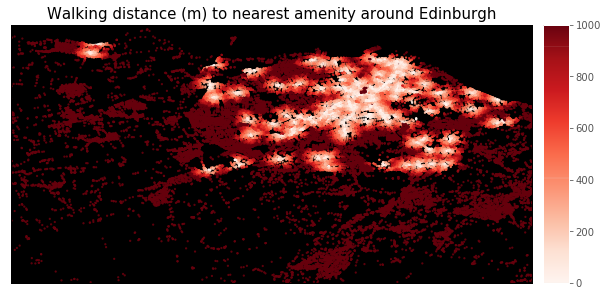

In [156]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Edinburgh', fontsize=15)
fig.savefig('/resources/Data_Science_Capstone/accessibility-Edinburgh.png', dpi=200, bbox_inches='tight')

As seen above, there are some zones where people have to walk more than 500 meters to reach the nearest amenity, whereas in Edinburgh's Old Town has walking distances of less than 100 meters on average.

The map shows the walking distance in meters from each network node to the nearest restaurant, bar, cafe, pub and Grocery shop. But, a better indicator of accessibility might be having access to a large number of amenities. So instead of the nearest, we plot accessibility to the fifth-nearest amenity:

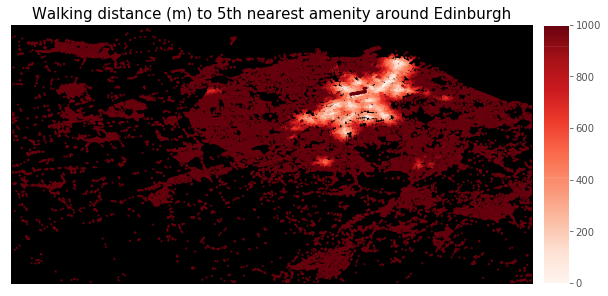

In [157]:
# distance to the 5th nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Edinburgh', fontsize=15)
fig.savefig('/resources/Data_Science_Capstone/accessibility-nearest5th-Edinburgh.png', dpi=200, bbox_inches='tight')

This time, is even more noticeable that Old Town and the city center area od Edinburgh is more accessible. 

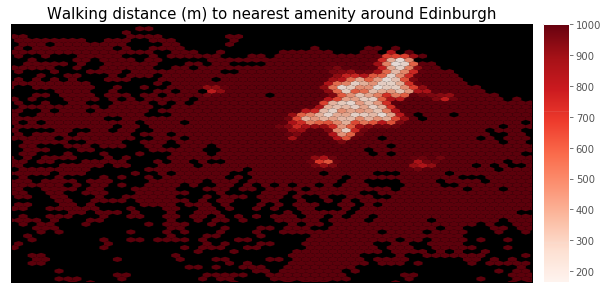

In [158]:
# distance to the 5th nearest amenity of any type, as hexbins
n=5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Edinburgh', fontsize=15)
fig.savefig('/resources/Data_Science_Capstone/accessibility-hexbins-Edinburgh.png', dpi=200, bbox_inches='tight')

Accessibility scores can quickly be constructed to answer a given question: whether it’s access to essential services, or walkable neighborhoods that appeal to young workers. For our purposes, access to restaurants, shops, cafes, bars and pubs are taken as essential for Airbnb users. So we are weighting all amenities equally and using distance to the fifth nearest amenity as a compound measure of accessibility. This gives a clearer picture of which neighborhoods are most walkable, compared with plotting just the distance to the single nearest venue/amenity.

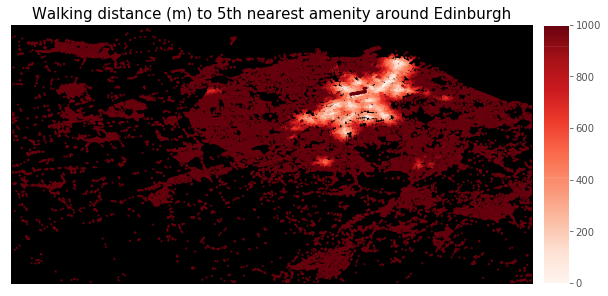

In [194]:
# distance to the 5th nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Edinburgh', fontsize=15)
fig.savefig('/resources/Data_Science_Capstone/accessibility-nearest5th-Edinburgh.png', dpi=200, bbox_inches='tight')

#### Setting distance to the fifth nearest amenity as a compound measure of accessibility

In [195]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

51,553 nodes


5
id            
354100  1000.0
354103  1000.0
354106  1000.0
363837  1000.0
363913  1000.0

#### Network aggregation

Here, we combine `Score`, our compound measure of accessibility (network distance from the node to the 5th nearest POIs) with the POIs dataset `df_pois`.

In [196]:
# We name our measure 'Score'
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

Get the nearest `node_id` for each POI, based on its lat-lon

In [197]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Venue Longitude'], df_pois['Venue Latitude'])
df_pois.head()

Neighbourhood  Neighbourhood Latitude  \
0                  Currie East               55.903039   
3   Baberton and Juniper Green               55.907728   
4   Baberton and Juniper Green               55.907728   
13     Colinton and Kingsknowe               55.910693   
24      Parkhead and Sighthill               55.922803   

    Neighbourhood Longitude                            Venue  Venue Latitude  \
0                 -3.302739                       Co-op Food       55.900378   
3                 -3.285077  Baberton Golf Course Club House       55.906364   
4                 -3.285077                 The Pentland Fry       55.903255   
13                -3.252197                     Colinton Inn       55.907514   
24                -3.278036             Scotmid Co-operative       55.924916   

    Venue Longitude Venue Category    node_ids  
0         -3.307181  Grocery Store  2607917051  
3         -3.289724            Bar  5721406045  
4         -3.285545     Restaurant  3294851822  
13        -3.256370            Bar   774626742  
24        -3.276178  Grocery Store    45014289

In [198]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [199]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

node_ids   Score
0    354100  1000.0
1    354103  1000.0
2    354106  1000.0
3    363837  1000.0
4    363913  1000.0

In [202]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [203]:
# Checking column types make sense
merged.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
node_ids                     int64
Score                      float64
dtype: object

In [204]:
merged.head()

Neighbourhood  Neighbourhood Latitude  \
0                 Currie East               55.903039   
1  Baberton and Juniper Green               55.907728   
2  Baberton and Juniper Green               55.907728   
3     Colinton and Kingsknowe               55.910693   
4      Parkhead and Sighthill               55.922803   

   Neighbourhood Longitude                            Venue  Venue Latitude  \
0                -3.302739                       Co-op Food       55.900378   
1                -3.285077  Baberton Golf Course Club House       55.906364   
2                -3.285077                 The Pentland Fry       55.903255   
3                -3.252197                     Colinton Inn       55.907514   
4                -3.278036             Scotmid Co-operative       55.924916   

   Venue Longitude Venue Category    node_ids   Score  
0        -3.307181  Grocery Store  2607917051  1000.0  
1        -3.289724            Bar  5721406045  1000.0  
2        -3.285545     Restaurant  3294851822  1000.0  
3        -3.256370            Bar   774626742  1000.0  
4        -3.276178  Grocery Store    45014289  1000.0

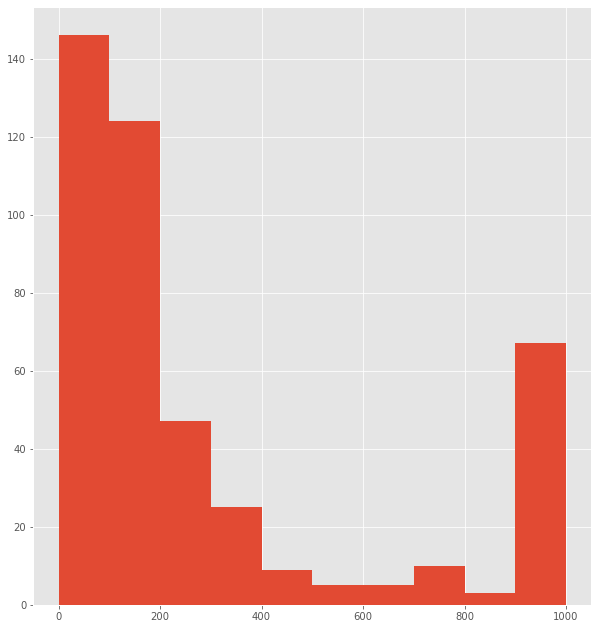

In [206]:
merged['Score'].hist(figsize=(10,11))

In [210]:
# Setting both columns have the same name for merging
df = df.rename(columns={'borough': 'Neighbourhood'})

In [211]:
# Merging by neighbourhoods
df_merged = pd.merge(merged, df, on='Neighbourhood')

In [214]:
# Save cleaned for modelling
df_merged.to_csv(r'/resources/Data_Science_Capstone/listings_model.csv', index=id, header=True)

### 6. Preparing data for modelling

#### Dropping columns and assessing multi-collinearity

Categorical variables will now be one-hot encoded:

The accessibility score `Score`(distance to the fifth nearest venue) is now applied to each listing, based on which neighbourhood they belong to. Thus, we no longer need the geographical data or the venue data.

In [33]:
# Open merged dataset for modelling
df_merged = pd.read_csv(r'/resources/Data_Science_Capstone/listings_model.csv', index_col=0)
df_merged.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude       Venue  \
0   Currie East               55.903039                -3.302739  Co-op Food   
1   Currie East               55.903039                -3.302739  Co-op Food   
2   Currie East               55.903039                -3.302739  Co-op Food   
3   Currie East               55.903039                -3.302739  Co-op Food   
4   Currie East               55.903039                -3.302739  Co-op Food   

   Venue Latitude  Venue Longitude Venue Category    node_ids   Score  \
0       55.900378        -3.307181  Grocery Store  2607917051  1000.0   
1       55.900378        -3.307181  Grocery Store  2607917051  1000.0   
2       55.900378        -3.307181  Grocery Store  2607917051  1000.0   
3       55.900378        -3.307181  Grocery Store  2607917051  1000.0   
4       55.900378        -3.307181  Grocery Store  2607917051  1000.0   

   host_response_time  ... outdoor_space  host_greeting  internet  \
0      within an hour  ...           0.0            1.0       1.0   
1             unknown  ...           0.0            0.0       1.0   
2  within a few hours  ...           1.0            0.0       1.0   
3             unknown  ...           1.0            1.0       1.0   
4             unknown  ...           0.0            0.0       0.0   

   long_term_stays pets_allowed private_entrance  secure  self_check_in  \
0              1.0          0.0              1.0     0.0            0.0   
1              0.0          0.0              0.0     0.0            0.0   
2              0.0          0.0              1.0     0.0            1.0   
3              0.0          0.0              0.0     0.0            0.0   
4              0.0          1.0              0.0     0.0            0.0   

   time_since_first_review  time_since_last_review  
0                2-3 years                     NaN  
1                      NaN                     NaN  
2                2-3 years                     NaN  
3                      NaN                     NaN  
4                2-3 years                 1+ year  

[5 rows x 58 columns]

In [34]:
# Dropping variables no longer needed
df_merged.drop(['Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Neighbourhood Latitude',
               'Venue Category', 'node_ids', 'Venue'], axis=1, inplace=True)

We get dummies for our categorical variables to get the dataset ready for multicollinearity analysis. 

In [35]:
transformed_df = pd.get_dummies(df_merged)
transformed_df.head()

Score  host_is_superhost  host_listings_count  host_identity_verified  \
0  1000.0                1.0                  2.0                     1.0   
1  1000.0                0.0                  1.0                     1.0   
2  1000.0                0.0                  1.0                     0.0   
3  1000.0                0.0                  1.0                     0.0   
4  1000.0                0.0                  1.0                     0.0   

   accommodates  bathrooms  bedrooms  beds  price  security_deposit  ...  \
0             2        1.0       0.0   1.0     51               100  ...   
1             2        1.0       1.0   1.0     30               100  ...   
2             4        1.0       2.0   3.0     60               100  ...   
3             6        2.0       3.0   3.0    170               150  ...   
4             2        1.0       1.0   1.0     29                 0  ...   

   time_since_first_review_0-6 months  time_since_first_review_1-2 years  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   time_since_first_review_2-3 years  time_since_first_review_4+ years  \
0                                  1                                 0   
1                                  0                                 0   
2                                  1                                 0   
3                                  0                                 0   
4                                  1                                 0   

   time_since_first_review_6-12 months  time_since_last_review_0-2 weeks  \
0                                    0                                 0   
1                                    0                                 0   
2                                    0                                 0   
3                                    0                                 0   
4                                    0                                 0   

   time_since_last_review_1+ year  time_since_last_review_2-6 months  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               1                                  0   

   time_since_last_review_2-8 weeks  time_since_last_review_6-12 months  
0                                 0                                   0  
1                                 0                                   0  
2                                 0                                   0  
3                                 0                                   0  
4                                 0                                   0  

[5 rows x 166 columns]

We now assess for multicollinearity of features:

In [18]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

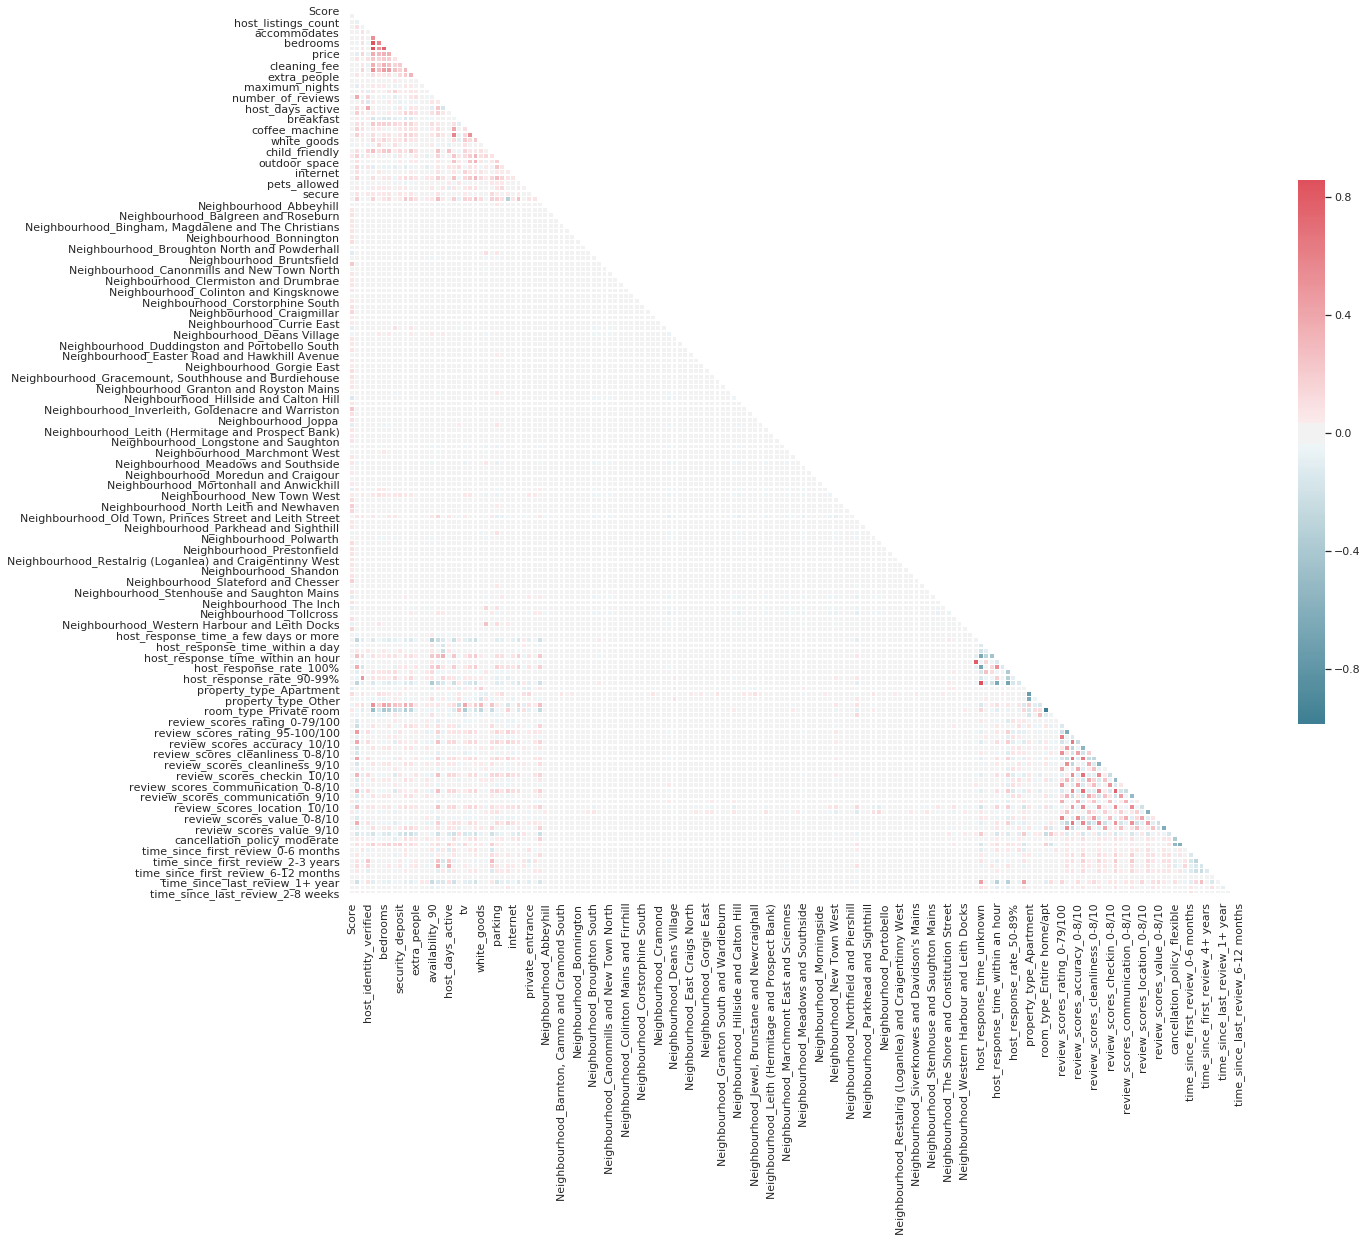

In [222]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with neighbourhood variables, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

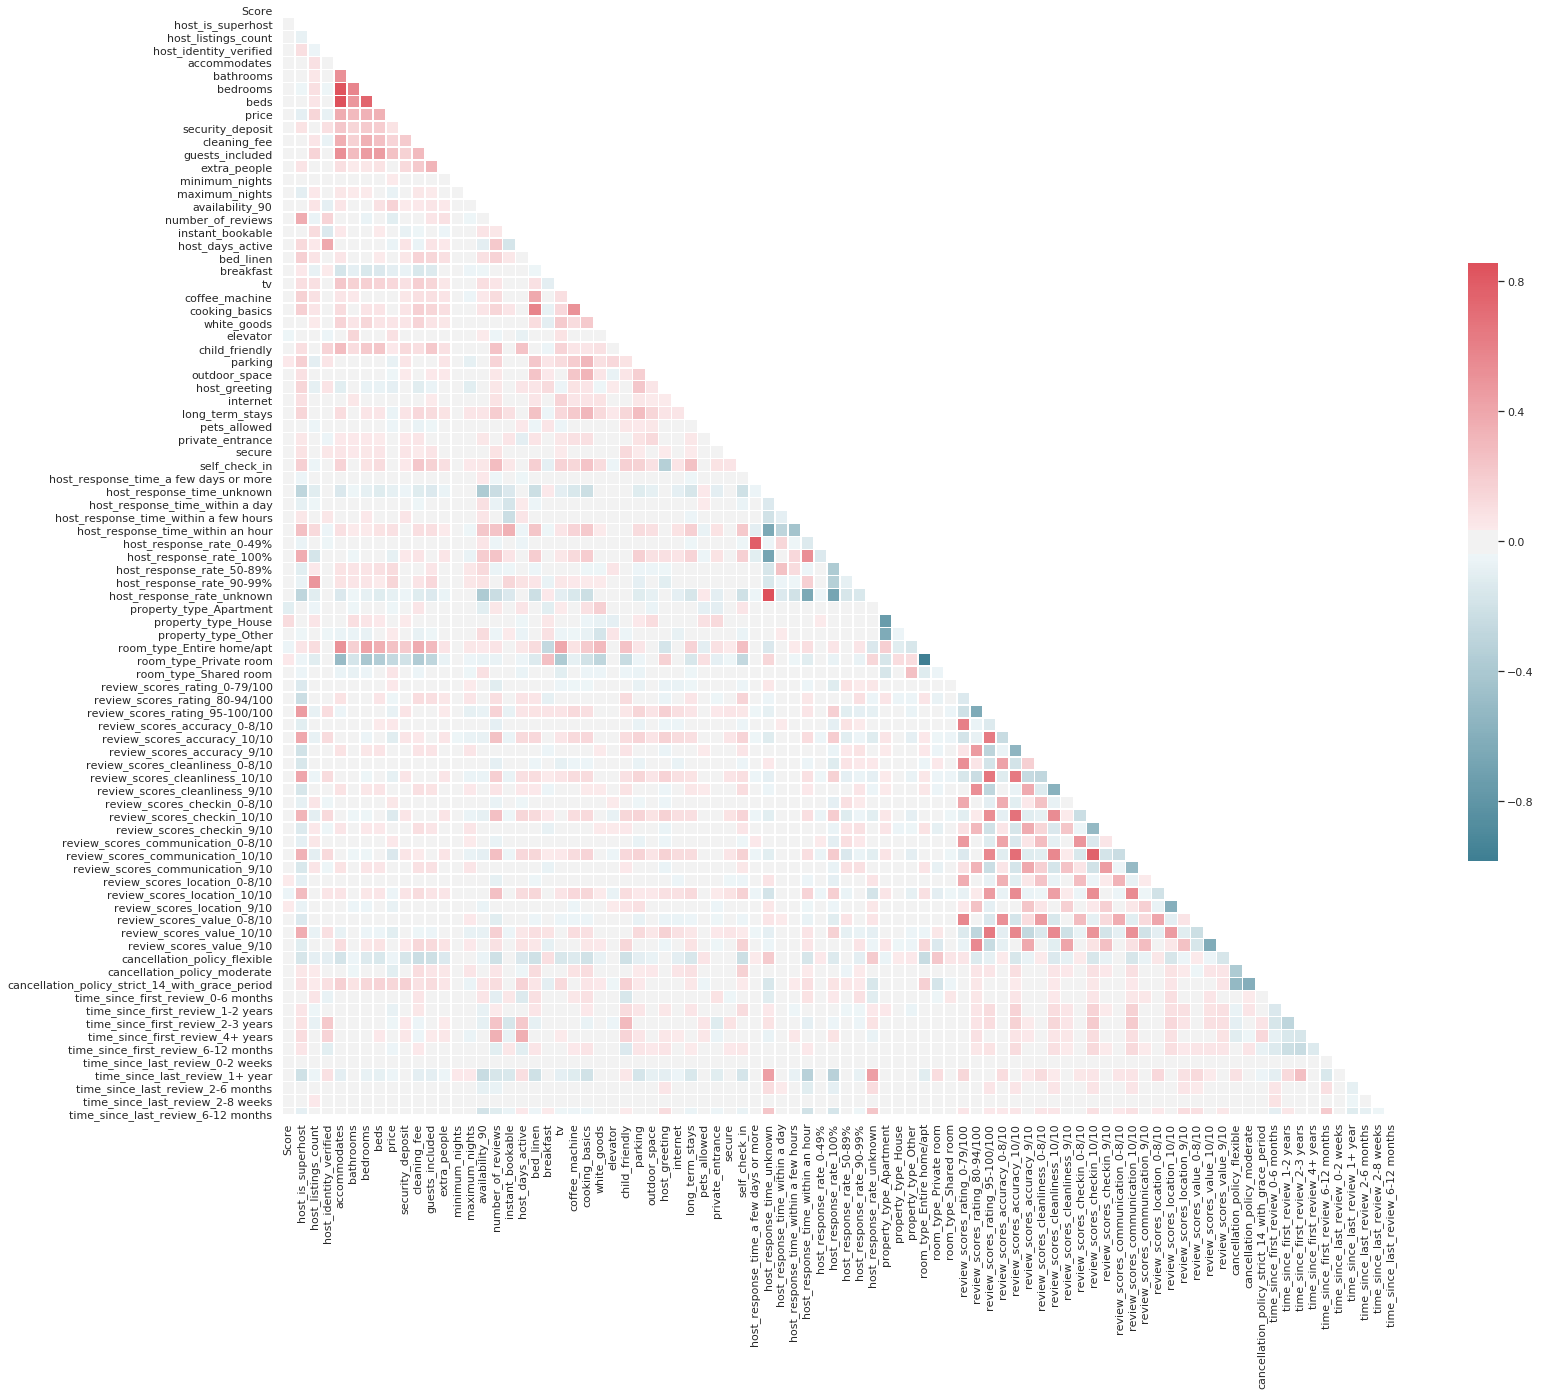

In [223]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

Areas of multi-collinearity:

- `Beds`, `bedrooms`, `guests_included` and the number of people that a property `accommodates` are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

- Unsurprisingly, there are perfect correlations between `NaN reviews` (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. `NaN` categories can therefore be dropped.

- The same is true of `host_response_rate_unknown` and `host_response_time_unknown`. One of these rates will be dropped.

- There is a correlation between `host_response_rate 0-49%` and `host_response_time_a few days or more`. One of these will be dropped.

- There are strong negative correlations between `property_type_House` and `property_type_Apartment`, and between `room_type_Private room` and `room_type_Entire_home_apt` (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [36]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

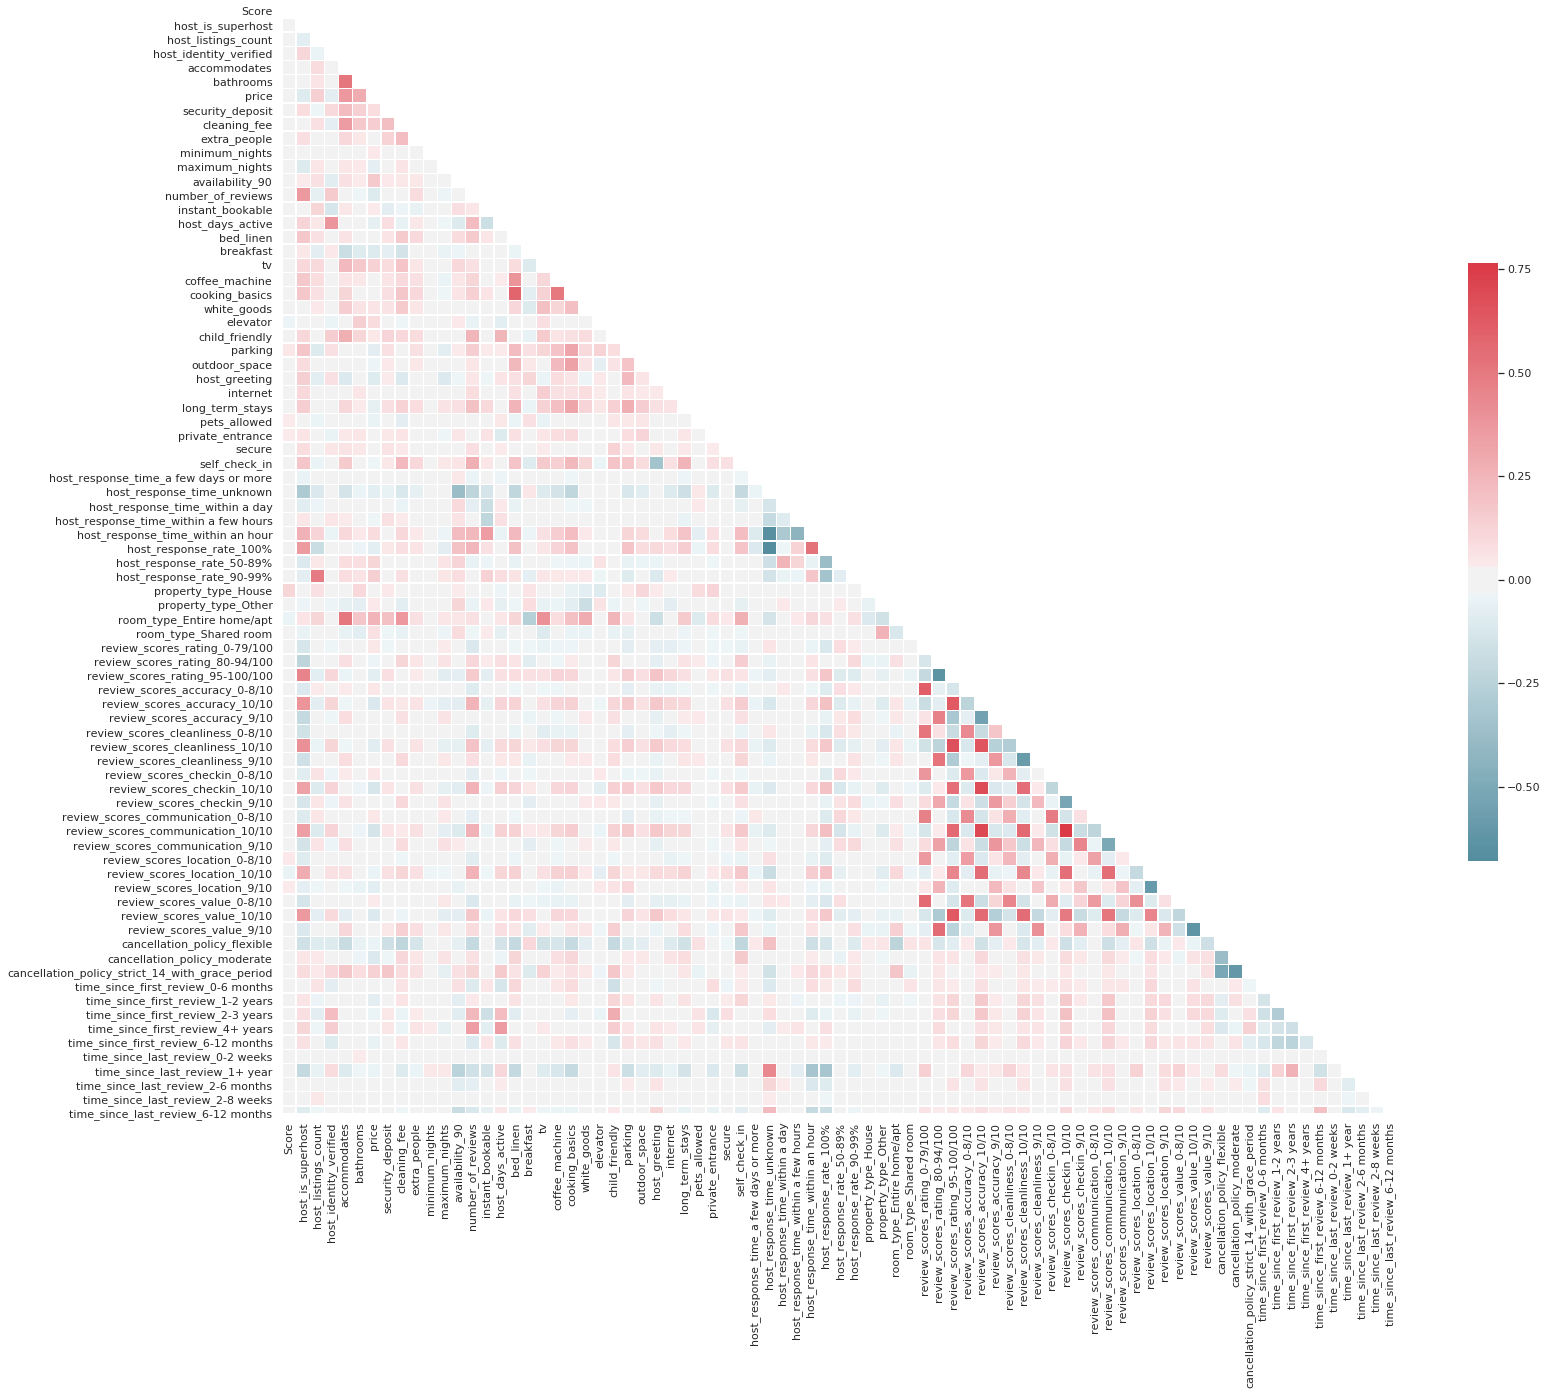

In [225]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

#### Standardising and normalising

Other than `availability_90` and `host_days_active`, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [37]:
numerical_columns = ['Score','accommodates', 'availability_90', 'bathrooms',
                     'cleaning_fee', 'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

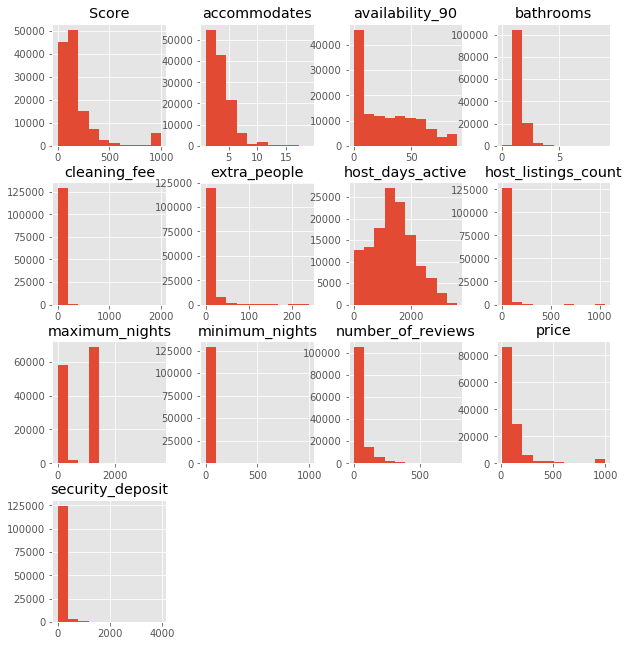

In [38]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [39]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. `cleaning_fee`, `extra_people` fee and `security_fee`) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

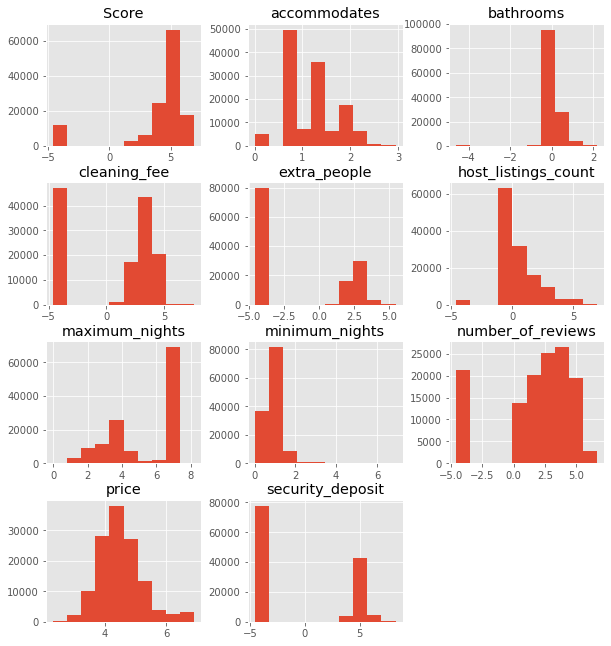

In [40]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features `X` and the target feature `y` can be separated, and `X` will be scaled. `StandardScaler` from `sklearn` will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

That is, we’ll separate the features and the target variable for modeling. We will assign the features (explanatory variables) to `X` and the target variable to `y`. We use `scaler.fit_transform()`, as mentioned above, to transform the `y` variable for the model. `transformed_df.drop([features], axis=1)` tells pandas which columns we want to exclude. We won’t include `price` for obvious reasons, and `ID` is just an index with no relationship to `price`.

In [41]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

### 7. Modelling

Now that the data preprocessing is over, we can start applying different Supervised Machine Learning models. We will compare two models:

- A **Spatial Hedonic Price Model** (OLS Regression), with the `LinearRegression` from Scikit-Learn library
- The **Gradient Boosting method**, with the `XGBRegressor` from the XGBoost library

The evaluation metrics used will be mean squared error (for loss) and r-squared (for accuracy).

In [42]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

#### Model 1: Spatial Hedonic Price Model (HPM)

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from **hedonic price theory** which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes [(Griliches, 1971)](https://www.hup.harvard.edu/catalog.php?isbn=9780674592582). Consumers are assumed to purchase goods embodying bundles of attributes that maximize their underlying utility functions [(Rosen, 1974)](https://econpapers.repec.org/article/ucpjpolec/v_3a82_3ay_3a1974_3ai_3a1_3ap_3a34-55.htm). 

In addition to the characteristics of the Airbnb listings, we add location features as they have been shown to be important factors in influencing the price (see [here](https://core.ac.uk/download/pdf/35467021.pdf), [here](https://www.aresjournals.org/doi/abs/10.5555/rees.32.3.d4713v80614728x1), [here](https://www-sciencedirect-com.ezproxy.napier.ac.uk/science/article/pii/S0169204610001775) and [here](https://www-sciencedirect-com.ezproxy.napier.ac.uk/science/article/pii/S0921800901002786) for examples). Ideally, Lagrange multiplier tests should be conducted to verify if there is spatial lag in the dependent variable and therefore a spatial lag model (see [this post](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) for spatial regression using  [Pysal](https://pypi.org/project/pysal/)) is preferred for estimating a spatial HPM. However, for the purposes of this post, we are only using a conventional OLS model for hedonic price estimation that includes spatial and locational features, but not a spatial lag that accounts for spatial dependence.

So, the first explanatory variables are the listings characteristics (`acommodates`, `bathrooms`, etc) and our second group of explanatory variables based on spatial and locational features are `Score`, which is the network distance to 5th nearest venue we computed with Pandana; and `Neighbourhood` belonging, `1` if the listing belongs to the specified neighbourhood, `0` otherwise.

In [46]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.2624
Validation RMSE: 0.2661

Training r2: 0.5196
Validation r2: 0.5108


This means that our features explain approximately 51% of the variance in our target variable. 

Interpreting the  ` mean_squared_error`value is somewhat more intuitive that the r-squared value. The RMSE measures the distance between our predicted values and actual values.

We can compare the actual output values for `X_test` with the predicted values in a dataframe:

In [47]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

Actual  Predicted
0      4.077537   4.187886
1      4.430817   4.787505
2      3.555348   3.728065
3      3.465736   3.200187
4      3.258097   3.540851
...         ...        ...
25806  3.713572   3.903128
25807  4.499810   5.246093
25808  4.795791   5.027282
25809  4.406719   4.319219
25810  4.110874   4.342290

[25811 rows x 2 columns]

And we can view this relationship graphically with a scatter plot:

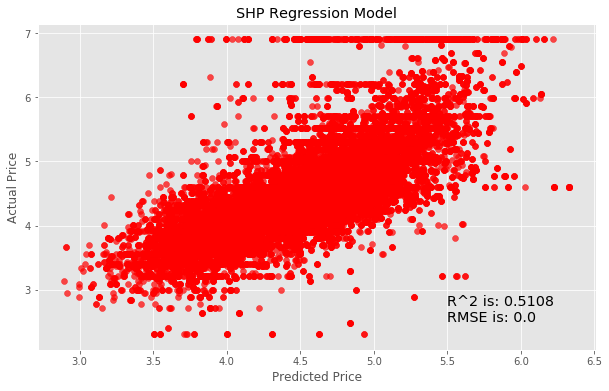

In [48]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

If our predicted values were identical to the actual values, this graph would be the straight line `y=x` because each predicted value x would be equal to each actual value y.

##### Improving our model

We can try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

We’ll once again instantiate the model. The Ridge Regularization model takes a parameter, alpha , which controls the strength of the regularization.

We’ll experiment by looping through a few different values of alpha, and see how this changes our results.

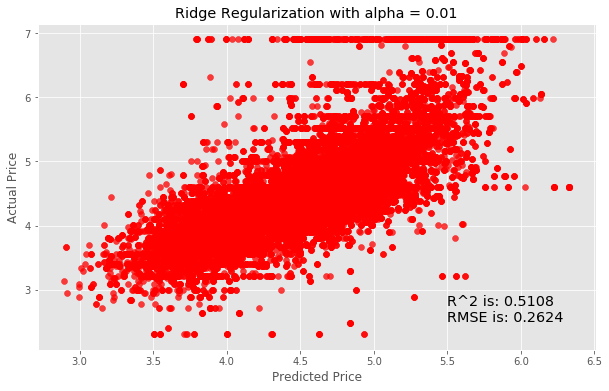

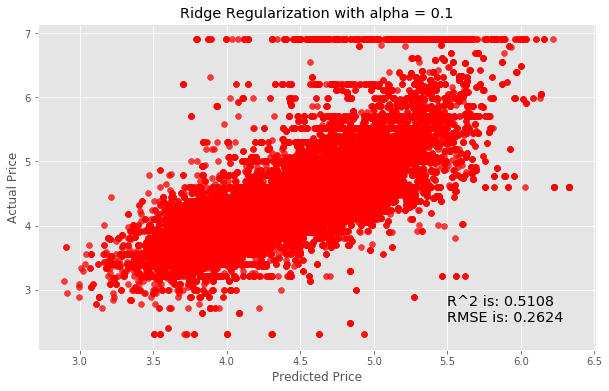

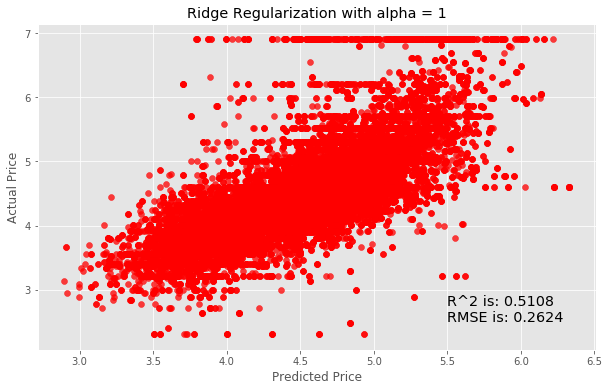

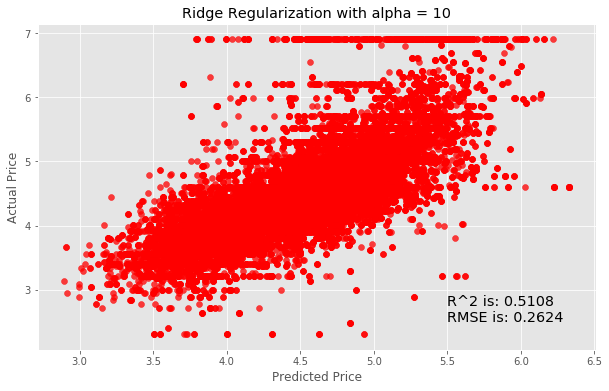

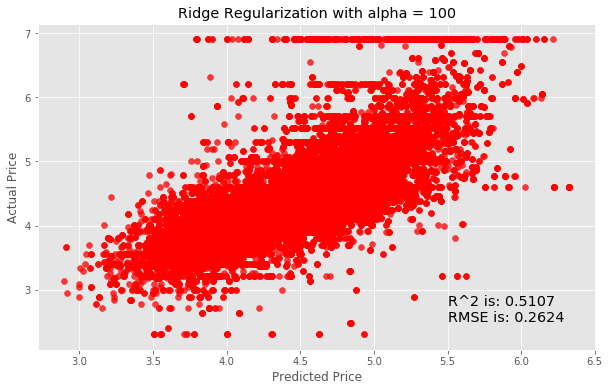

In [50]:
lr = linear_model.LinearRegression()

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='r')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                   round(ridge_model.score(X_test, y_test), 4),
                    round(mean_squared_error(y_train, training_preds_hpm_reg),4))
    plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
    plt.show()

These models perform almost identically to the first model. In our case, adjusting the alpha did not substantially improve our model. 

#### Model 2:  Gradient boosted decision trees

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

XGBoost (e**X**treme **G**radient **Boost**ing) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both regression and classification predictive modeling problems. For more information see [here](https://www.youtube.com/watch?v=Vly8xGnNiWs) to listen to Tianqi Chen, the creator of the XGBoost library.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to our Hedonic regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [51]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[16:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.6 minutes

Training MSE: 0.1881
Validation MSE: 0.1923

Training r2: 0.6557
Validation r2: 0.6465


This means that our features explain approximately 65% of the variance in our target variable. 

##### Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

For more detailed information on how feature importance is calculated in boosted decision trees, see [this answer in StackOverflow](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting).

In [52]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

weight
room_type_Entire home/apt     0.332004
accommodates                  0.090831
property_type_Other           0.065888
bathrooms                     0.034101
cancellation_policy_moderate  0.031358
availability_90               0.029539
number_of_reviews             0.027489
host_listings_count           0.025593
minimum_nights                0.019489
cleaning_fee                  0.019487

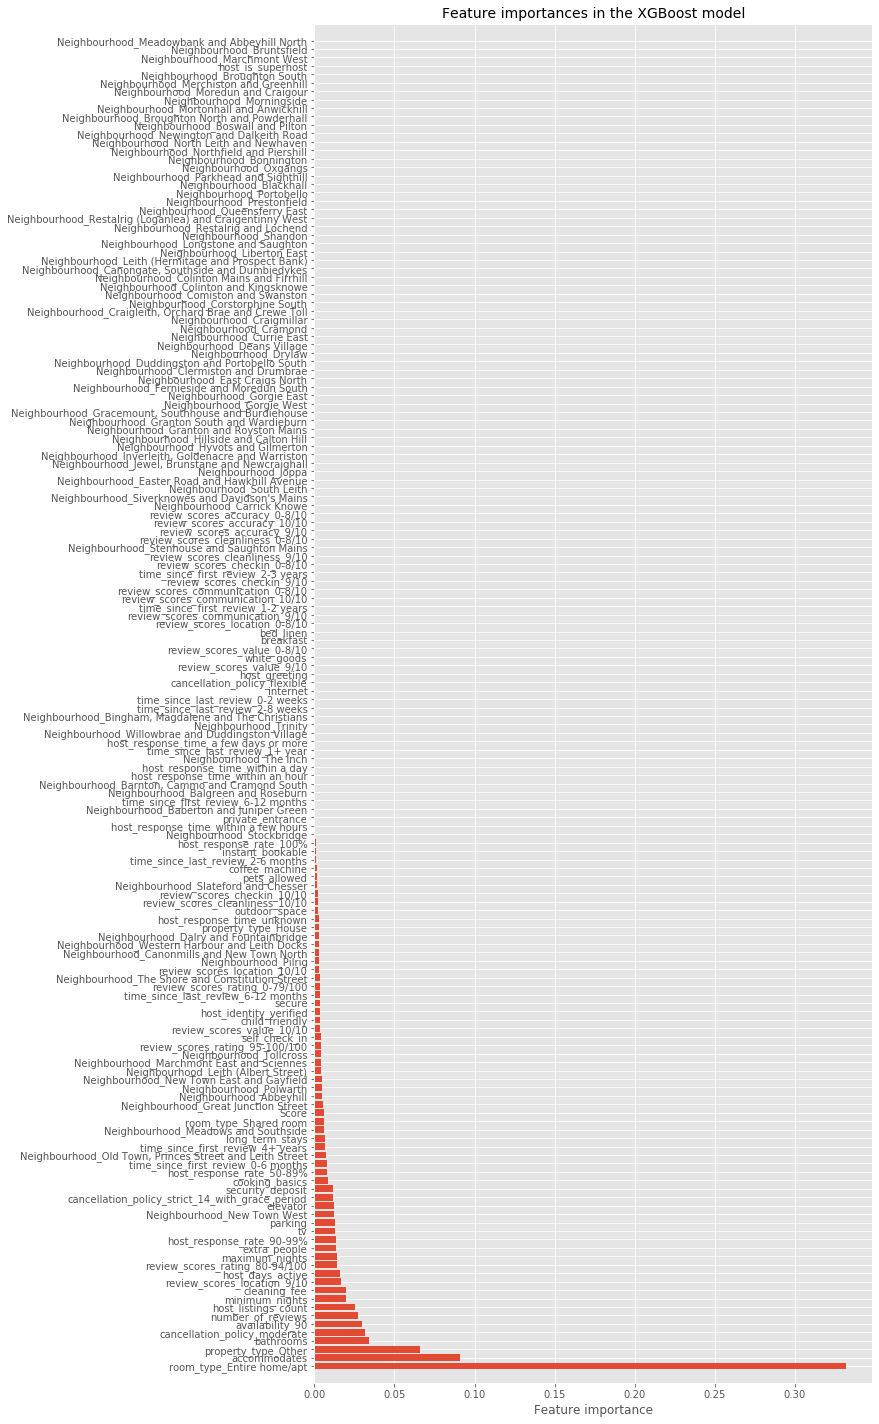

In [53]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

About a good number of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed.

The top 10 most important features are:

1. If the rental is the entire flat or not `room_type_Entire home/apt`
2. How many people the property accommodates (`accommodates`)
3. The type of property (`property_type_Other`)
4. The number of bathrooms (`bathrooms`)
5. How many days are available to book out of the next 90 (`availability_90`)
6. The number of reviews (`number_of_reviews`)
7. The cancellation policy being moderate (`cancellation_policy_moderate`)
8. How many other listings the host has (`host_listings_count`)
9. The minimum night stays (`minimum_nights`)
10. The maximum nights stay (`maximum_nights`)

The most important features the rental being the entire flat. Which makes sense. Asking price is higher if the offer is for the entire flat/house. This could also suggest that offering the flat/house as a whole, rather than each bedroom individually, may be better overall, given the large difference in importance compared to the second most important feature.

It is not surprising that the second how many people the property accommodates, as that's one of the main things you would use to search for properties with in the first place.

It is perhaps more surprising that location features did not appear in the top ten. Although we can observe that belonging to a certain neighbourhood increases price more than others and `Score` (accessibility measure) also shows some importance, they are of relative low importance compared to the top 3 features. `Review Scores Location` is higher on the importance list (number 11). This is, it is likely renters put more weight in other's opinion about location instead of judging the location based on neighbourhood and venues around the property. This could also be because Edinburgh is a small and walkable city with good transportation services. Thus, location is not a major problem to reaching main touristic attractions and amenities.

The eight most important feature is related to how many other listings the host manages on Airbnb, rather than the listing itself. This result showed on [this analysis](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Categorical-features) of Airbnb listings in London, only this feature was the third most important. What the researcher (and former data scientists at an Airbnb management company) explains is that this does not mean that a host that manages more properties will result in a listing gaining higher prices, and could be due to experienced hosts setting higher prices. Also, it could be that big Airbnb management companies that have lots of listings tend to manage more expensive properties than single listing hosts.

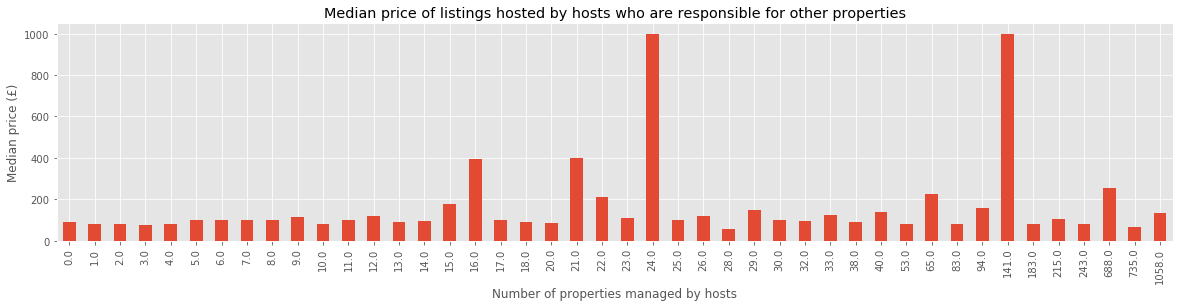

In [54]:
# Median price for different host listing counts
plt.figure()
df_merged.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

#### Improving models

In the 'Preparing the data for modeling' section above, it was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance.

This model will drop review columns other than the overall review rating, and use the same Hedonic regression and XGBoost structure, in order to see whether this produces a better models.

Columns will be dropped from the existing `X_train` and `X_test` split, for consistency.

In [55]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

#### Model 3: Hedonic regression with dropped columns

In [56]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))

Time taken to run: 0.0 minutes

Training RMSE: 0.2624
Validation RMSE: 0.2661

Training r2: 0.5196
Validation r2: 0.5108


#### Model 4: XG Boost with dropped columns

In [57]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg2),4))

[16:14:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.6 minutes

Training MSE: 0.1881
Validation MSE: 0.1923

Training r2: 0.6557
Validation r2: 0.6465


Both Spatial Hedonic Regression and XGBoost perform almost exactly the same without the additional review columns.

Hence, because they are able to achieve the same performance with 18 fewer columns, the second models are the preferred models as they require less data and are less computationally expensive.

#### Final model selection

Overall, the XGBoost model (Model 4) is the preferred model, which performs better than both Spatial Hedonic Regression Models and just as good as the first model but is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.

### Conclusions and Recommendations

The best performing model was able to predict 65.56% of the variation in price with an RMSE of 0.19. Which means we still have a remaining 34.44% unexplained. This could be due to several other features that are not part of our dataset or the need to analyse our features more closely.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model (see [here](https://arxiv.org/pdf/1907.12665.pdf) for an example).

Another suggestion is the inclusion of image quality as a feature. Using Difference-in-Difference deep learning and supervised learning analyses on a Airbnb panel dataset, researchers found that units with verified photos (taken by Airbnb’s photographers) generate additional revenue per year on average ([see here](https://poseidon01.ssrn.com/delivery.php?ID=204024105119026094069105008103096093034021070051045032025117103105027080085099113011048103001010014121023024085079004082003114107082070089028074094097015117086091125049040024103012093025001119016069070080070120120094005077005088015116003064009008121126&EXT=pdf)). 

It was noticeable that reviews about listing location, rather than the location features themselves, were higher in the feature importance list. This, this finding could perhaps be used by Airbnb hosts when writing their listing's description. Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing. 